<a href="https://colab.research.google.com/github/kakou34/CS_project_LeCreusot/blob/main/Augmented_skin_lesion_segmentation_DL_OLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Skin Lesion Segmentation with Deep Learning - With Data Augmentation***

In this notebook we will train deep learning models to perform skin lesion segmentation. 

We will use the ISIC2017 dataset that we augmented using Ablumentations library. 

The augmented dataset contains 3000 Training images and 1000 (the original) test images. 

Among the 1000 test images we will be using randomly selected 300 images to validate the training procedure. 

Please find the dataset used in the following Google Drive directory: 
https://drive.google.com/drive/folders/1zenvA0gBriURnJKrxh91qBs5A3YRYWY2?usp=sharing

The dataset directory contains the followings: 


*   ***img***: (folder) contains 6000 skin dermatoscopy images from which 2000 are the original images from ISIC2017 and the remaining 4000 are obtained by data augmentation. 
*   ***img.zip***: the compressed version of the img.
*   ***mask.zip***: a compressed folder that contains the corresponding 6000 segmentation masks (ground truth).
*   ***aug_train.csv***: contains the image IDs and the classification labels of the 3000 training images obtained from data augmentation. 
*   ***test.csv***: contains the image IDs and classification labels for the 1000 images used for testing the algorithms.
*   ***val.csv***: contains the image IDs and classification labels of 300 images selected randomly from the augmented test images and used for validation. 








Check GPU type

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 28 21:37:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# trick to avoid being disconnected from colab
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# **Preparing the necessary folders**

## *Mount drive*

Our images and masks are stored in Google drive. We need to mount Drive to Colab to have access to the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## *Unzip image folders*

Since the Ground Truth images are stored in the compressed folder mask.zip we need to extract them to a folder first. This is achieved using the following command: 

--> If your folder is somewhere else please change the file path

In [ ]:
!unzip /content/drive/MyDrive/augmented_isic/mask.zip

Streaming output truncated to the last 5000 lines.
  inflating: mask/ISIC_0000397_1_segmentation.png  
  inflating: mask/ISIC_0000397_segmentation.png  
  inflating: mask/ISIC_0000403_0_segmentation.png  
  inflating: mask/ISIC_0000403_1_segmentation.png  
  inflating: mask/ISIC_0000403_segmentation.png  
  inflating: mask/ISIC_0000407_0_segmentation.png  
  inflating: mask/ISIC_0000407_1_segmentation.png  
  inflating: mask/ISIC_0000407_segmentation.png  
  inflating: mask/ISIC_0000408_0_segmentation.png  
  inflating: mask/ISIC_0000408_1_segmentation.png  
  inflating: mask/ISIC_0000408_segmentation.png  
  inflating: mask/ISIC_0000409_0_segmentation.png  
  inflating: mask/ISIC_0000409_1_segmentation.png  
  inflating: mask/ISIC_0000409_segmentation.png  
  inflating: mask/ISIC_0000410_0_segmentation.png  
  inflating: mask/ISIC_0000410_1_segmentation.png  
  inflating: mask/ISIC_0000410_segmentation.png  
  inflating: mask/ISIC_0000412_0_segmentation.png  
  inflating: mask/ISIC_00

# **Libraries**

## *Install*

In this section we install libraries that are not included in Google Colab

In [ ]:
# If you get an error importing opencv run this 

# !pip uninstall opencv-python-headless==4.5.5.62 
# !pip install opencv-python-headless==4.1.2.30

# Library used to find the optimal threshold
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=74beb44f65f467d78c9285e21562b21856c7622f0c3e009d89561b5ae34f50c6
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


## *Import*

In this section we import the packages and libraries for future use

In [ ]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage import io
import cv2 as cv
import math

# Sci-kit learn
from sklearn.metrics import jaccard_score

#Pytorch 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

# Some training libraries
from tqdm import tqdm

# Threshold optimization library 
from bayes_opt import BayesianOptimization

# **Helper functions**

In this section we define different utils/helper function that will be usefull for the rest of the notebook

##  *Visualization*

In [ ]:
# A Function that uses Matplotlib's PyPlot to show an image stored in a pytorch tensor 
def imshow(inp, title=None):
  """
    Parameters: 
      * inp: the image that we want to show (it needs to have 3 channels, numpy does not show grayscale images)
      * title (optional): the title to show with the image
  """
  inp = inp.numpy().transpose((1, 2, 0)) # Convert from HxWxC format of tensor to CxHxW format of numpy

  plt.imshow(inp) # Show the image 
  if title is not None:
      plt.title(title) # Add a title if provided
  plt.pause(0.001)  # pause a bit so that plots are updated

## *Loss functions*

In this section we implement loss functions that are not available in Pytorch's nn module

### Dice with Binary Cross Entropy 

This loss function is a combination of the Dice loss and the Binary Cross Entropy loss. 

It is given by the sum of the dice loss and the BCE loss. 

+ The Dice loss is given by (1 - DCS) with the DCS (Dice score) given by the following formula: 

Dice.svg


+ The BCE Loss on the other hand is given by: 

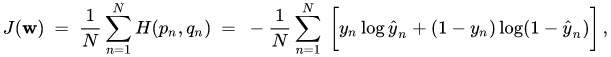

(Special case of the cross entropy loss when we have only 1 object to segment (2 classes: 1 object + the background


* Combining the two objective functions allows for some diversity in the loss, while benefitting from the stability of BCE which is the standard loss function used for segmentation. 



In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate BCE Loss (after a softmax that is applied internally) using the official function from PyTorch
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        # Calculate Dice Loss
        inputs = torch.sigmoid(inputs) # Apply the sigmoid activation function 
        intersection = (inputs * targets).sum()  # computer the intersecction between the label and target                         
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) # dice loss = 1 - DCS  
        
        # Combine losses 
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

## Evaluation metrics

### Jaccard Score

This function computes the Jaccard Score obtained from the segmentation of all images in a dataloader given by a model according to a given threshold. 

The Jaccard Score is given by the following formula (Intersection over Union):
 
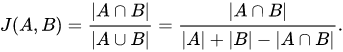 

In [ ]:
# A function that calculates the average Jaccard Score for all images in a dataloader
def check_js(loader, model, threshold= 0.5, device="cuda"):
  """
    Parameters: 
      * loader: a pytorch dataloader containing the images to be segmented and their corresponding GT 
      * model: the DL model used to segment the images 
      * threshold: a value between 0 and 1 used to threshold the segmentation result of the model. 
                  (values lower than threshold are mapped to 0, values higher than threshold are mapped to 1)
      * device: "cuda" if we want to use the GPU, "cpu" otherwise
  """
  model.eval() # Switch model to evaluation mode 
  j = 0; # initial Jaccard counter

  with torch.no_grad(): # do not calculate gradients in evaluation
        for batch in loader: # for each batch in the data loader do the following:
            x, y = batch['image'], batch['mask']
            x = x.float().to(device)

            preds = torch.sigmoid(model(x)) # Calculate predictions given by the model
            # Next the binary mask is obtained
            preds = (preds > threshold).int() # consider pixels with value higher than threshold to be part of the lesion, others are background
            y = y.cpu().numpy().reshape(-1)
            preds = preds.cpu().numpy().reshape(-1)

            j += jaccard_score(y, preds) # Calculation of the Jaccard score and summing it to all other batches.

        js = j/len(loader) # calculating the average Jaccard score

  model.train() # swich model back to train mode 
  return js

### Dice Score

This function calculates the Dice score of a segmented image given by the formula:

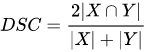

In [ ]:
def get_dice(inputs, targets, smooth = 0.00004):
  """
    Parameters: 
      * inputs: the segmentation result of the model for an image or a batch of images 
      * targets: the corresponding GT of the given image/batch
      * smooth: a small number used to avoid division by 0
  """
  # Apply sigmpoid on the inputs to obtain pixel membership probabilities (between 0 and 1)
  inputs = torch.sigmoid(inputs)       
        
  #flatten label and prediction tensors
  inputs = inputs.view(-1)
  targets = targets.view(-1)
        
  intersection = (inputs * targets).sum()                            
  dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
  return dice

## *Testing*

In [ ]:
# A function to evalute the average dice score and the loss for all the images in a dataloader
def evaluate(net, dataloader, criterion, device):
    """
      Parameters: 
        * net: the DL model to be evaluated 
        * dataloader: pytorch dataloader containing the images to be segmented and their corresponding manual GT 
        * criterion: the loss function 
        * device: "cuda" if the GPU is used, "CPU" otherwise
    """
    net.eval() # Switch net to evaluation mode
    num_val_batches = len(dataloader) # get the number of batches in dataloader
    dice_score = 0 # initialize dice sum counter
    loss = 0 # initialize loss sum counter
    # iterate over each batch the validation set (dataloader)
    with tqdm(total=num_val_batches , desc=f'Valid', unit='img') as pbar:
      for batch in dataloader:
        image, gt = batch['image'], batch['mask'] 
        # move images and labels to correct device with the correct type
        image = image.to(device=device, dtype=torch.float32)
        gt = gt.unsqueeze(1).to(device=device)

        with torch.no_grad(): # Do not calculate gradient during validation
          
          pred = net(image) # predict the mask
          pbar.update(image.shape[0]) # update the progress bar
          loss_b = criterion(pred.view(-1), gt.view(-1)) # calculate the loss of the current batch
          loss += loss_b
          
          d = get_dice(pred, gt) # calculate the dice
          dice_score += d
        pbar.set_postfix(**{'dice ': d.item(), 'loss ': loss_b.item()}) 

    net.train() # Switch model back to train mode

    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return dice_score, loss
    dice_score_avg = dice_score / num_val_batches # calculate the average dice for all the set
    loss_avg = loss / num_val_batches # calculate the average loss for all the set
    return dice_score_avg , loss_avg # return the average dice and average loss

In [ ]:
# Function to segment 1 image using a given model and a threshold
def predict(image, model, threshold):
  image = image.unsqueeze(0).float().to(DEVICE) # add a batch dimension to the image and transfer it to the device
  preds = torch.sigmoid(model(image)) # Computer the segmentation prediction given by the
  preds = (preds > threshold).int() # binarize the segmentation using the threshold

  preds = preds[0, :, :, :] # extract the segmentation from the output
  preds = preds.cpu().detach().numpy().transpose((1, 2, 0))*255 # convert from Tensor to Numpy image

  p =  preds.astype(np.uint8)

  return p.squeeze(axis=2) 

# **Dataset Definition and Split**

## Custom ISIC2017 Dataset

Next, we create a custom Pytorch dataset class for ISIC2017 data

In [ ]:
# Parameters 
# Please change to the corresponding path if not the same in your device
img_folder = '/content/drive/MyDrive/augmented_isic/img'
seg_folder = '/content/mask'
train_csv_path = '/content/drive/MyDrive/augmented_isic/aug_train.csv'
test_csv_path = '/content/drive/MyDrive/augmented_isic/test.csv'
val_csv_path = '/content/drive/MyDrive/augmented_isic/val.csv'

In [ ]:
# This will be used in normal RAM mode (we fetch the images only when needed)
class ISIC2017Dataset(Dataset):
    """ISIC2017 dataset"""

    def __init__(self, csv_file, image_folder, segmentation_folder, img_transform=None, mask_transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with image paths & classification labels.
            image_folder (string): Path to the folder where the PNG images are located
            segmentation_folder (string): Path to the folder where the segmentation labels are located
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.path_df = pd.read_csv(csv_file) # pandas dataframe containing the image IDs
        self.image_folder = image_folder # path to the folder containing the original images 
        self.segmentation_folder = segmentation_folder # path to the folder containing the GT images
        self.img_transform = img_transform # image transform for the images 
        self.mask_transform = mask_transform # image transform for the masks
        

    def __len__(self):
        return len(self.path_df) # return the number of images in the dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

       
        img_id = '/' + self.path_df.iloc[idx]['image_id'] # obtain image file name start 
        
        img_path = self.image_folder+img_id + '.jpg' # file path of the original image 
        image = Image.open(img_path)  # open the original image as RGB

        
        mask_path = self.segmentation_folder+ img_id + '_segmentation.png' # file path of the mask
        mask = Image.open(mask_path).convert('1') # open the GT segmentation mask as binary


        # If a transform is provided apply it (Preprocessing)
        if self.img_transform:
            image = self.img_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        # return the image, the segmentation label
        return {
            'image': image,
            'mask': mask,
          }

In [ ]:
# Here we load all data when creating the dataset
# High-RAM is needed
class ISIC2017Dataset2(Dataset):
    """ISIC2017 dataset"""

    def __init__(self, csv_file, image_folder, segmentation_folder, img_transform=None, mask_transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with image paths & classification labels.
            image_folder (string): Path to the folder where the PNG images are located
            segmentation_folder (string): Path to the folder where the segmentation labels are located
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.path_df = pd.read_csv(csv_file) # pandas dataframe containing the image IDs
        self.image_folder = image_folder # path to the folder containing the original images 
        self.segmentation_folder = segmentation_folder # path to the folder containing the GT images
        self.img_transform = img_transform # image transform for the images 
        self.mask_transform = mask_transform # image transform for the 
        
        self.images = []
        self.masks = []

        for idx, row in self.path_df.iterrows():
            

            img_id =f'/' + row['image_id'] 

            img_path = img_folder + img_id + '.jpg' # path of the original image
            mask_path = seg_folder + img_id + '_segmentation.png' # path of the segmentation ground truth

            image = Image.open(img_path) # read the image
            mask = Image.open(mask_path).convert('1') # read the ground truth as a binary image

            if self.img_transform:
              image = self.img_transform(image) # if given, apply transform on the image

            if self.mask_transform:
              mask = self.mask_transform(mask) # if given, applu transform on the mask

            self.images.append(image) # store the image to the images list
            self.masks.append(mask) # store the mask to the masks list

        
    def __len__(self):
        return len(self.images) # return the number of images in the dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() # get index as list element instead of tensor

        image = self.images[idx] # fetch the image from the images list (in RAM)
        mask = self.masks[idx] # fetch the mask from the masks list (in RAM)
        return {
            'image': image,
            'mask': mask,
          }

## *Data Transforms & Preprocessing*




- In this section we define custom datatransforms that we will use to preprocess the images before feeding them to the network

--> In this transform we convert a rectangular image to a square image by padding 0s for the mask and 255s to the images in order to keep the aspect ratio when resizing to a smaller square to feed the model

In [ ]:
# Pad to square size: 
class MakeSquare(object):
    def __init__(self, is_mask):
        self.is_mask = is_mask
    def __call__(self, img):
        x, y = img.size # obtain the number of rows x and columns y of the image 
        size = max(x, y) # the new size is the largest of the two dimensions
        if self.is_mask:
            new_im = Image.new('1', (size, size), 0) # if the input is a segmentation mask (1 channel) initialize the new image to all black (0)

        else:
            new_im = Image.new('RGB', (size, size), (255,255,255)) # if the input is an original image (RGB) initialize the new square image to all white

        new_im.paste(img, (int((size - x) / 2), int((size - y) / 2))) # copy the original input to the middle of the new image 
        return new_im # return the new image

# Model Architectures 

In this section we define the model architectures using PyTorch

### U-Net

Reference: https://github.com/milesial/Pytorch-UNet

Building blocks

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # use transpose-convolution (returns a larger image with less channels) 
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1) # make the input larger in HW and less in C
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # pad the input x1 to have the same size as x2 (coming from the encoder)
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1) # concatenate x2 coming from the encoder and x1 the decoder's current input 
        return self.conv(x)

# last layer, 1 convolution with 1*1 kernel
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

U-net model

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels # number of channels in the input
        self.n_classes = n_classes # number of objects to be segmented, in our case 1 => the lesion
        self.bilinear = bilinear # whether to use bilinear upsampling or transposed convolution at the decoder for upsampling 

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # last conv layer
        logits = self.outc(x)
        return logits

## U-Net with Attention

Reference: https://github.com/LeeJunHyun/Image_Segmentation/blob/master/network.py

A Unet model with an attention block at the decoder level

In [ ]:
# Double Convolution, each followed by a Batch Normalization and ReLU
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

# Up-convolution at the decoder level
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		        nn.BatchNorm2d(ch_out),
			      nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

# Single convolution for the last layer
class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

# Attention mechanism
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x

In [ ]:
class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5) # Upsample
        x4 = self.Att5(g=d5,x=x4) # Attention Block 
        d5 = torch.cat((x4,d5),dim=1) # Concatenate current result d5 with the result of the corresponding encoder layer with attention x4
        d5 = self.Up_conv5(d5) # Apply a double convolution
        
        # Repeat
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        # Last convolution layer with kernel size 1
        d1 = self.Conv_1x1(d2)

        return d1

## ResNet-UNet

Reference: https://github.com/usuyama/pytorch-unet

A Unet model with a pre-trained ResNet18 as a bottleneck (encoder) 

Different from the reference's implementation, we used a Transpose convolution for up-sampling at the decoder level instead of the bilinear upsampling to enable learning more features.

In [ ]:
# Convolution followed by a ReLU
def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True) # Get ResNet18 model from torchvision
    self.base_layers = list(self.base_model.children()) # extract the layers of ResNet18 to a list

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    # Double the size keeping the same number of channels each time
    self.up3 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
    self.up2 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
    self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):

    # Encoder => a ResNEt18 forward
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)

    # Decoder
    x = self.up3(layer4) # Upsample
    layer3 = self.layer3_1x1(layer3) # Corresponding encoder result
    x = torch.cat([x, layer3], dim=1) # Concatenate the upsampled features with the corresponding layer from the encoder path
    x = self.conv_up3(x) # Apply a double convolution 

    # Repeat
    x = self.up3(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.up2(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.up2(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.up1(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x) # Result should have the same size as the input 

    out = self.conv_last(x) # Last convolution layer with kernel size 1

    return out

# **Training & Evaluation**





In this section we will train the different arcitectures  using different hyperparameters

## 1. *Simple U-NET*

### Prepare data

#### Data Transforms

In [ ]:
# Parameters
NEW_SIZE = 512

# Calculated from the original training set 
mu = [0.7145, 0.6030, 0.5589] # mean
std =  [0.1064, 0.1277, 0.1493] # Standard deviation

In [ ]:
# Transforms for preprocessing, we will use the same for all datasets here
img_transforms = transforms.Compose([
                                    MakeSquare(is_mask= False), # For original images
                                    transforms.Resize((NEW_SIZE, NEW_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mu, std=std)
                                  ]) 

mask_transforms = transforms.Compose([
                                    MakeSquare(is_mask= True), # For segmentation masks 
                                    transforms.Resize((NEW_SIZE, NEW_SIZE)),
                                    transforms.ToTensor(),
                                  ])

#### Datasets 

In [ ]:
# Training dataset, will contain 3000 images after augmentation
# SWITCH TO ISIC2017Dataset2 if you want to store all images in RAM instead of reading them at training/evaluation time
isic_train = ISIC2017Dataset(csv_file=train_csv_path,
                             image_folder= img_folder,
                             segmentation_folder= seg_folder, 
                             img_transform = img_transforms,
                             mask_transform = mask_transforms)

# Validation dataset, will contain 300 images from the augmented test set
isic_val = ISIC2017Dataset(csv_file=val_csv_path, 
                            image_folder= img_folder, 
                            segmentation_folder= seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms)

In [ ]:
# Test dataset, will contain the original 1000 images from ISIC2017
isic_test = ISIC2017Dataset(csv_file=test_csv_path, 
                            image_folder= img_folder, 
                            segmentation_folder= seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms)

#### Data Loaders

In [ ]:
# Parameters
TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
NUM_WORKERS = 2

In [ ]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(isic_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(isic_test, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(isic_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

Visualize some images : 

In [ ]:
iterator = iter(test_loader)

In [ ]:
# Get a batch of training data
data = next(iterator)

inputs = data['image']
masks = data['mask']

# Print shapes
print(inputs.shape)
print(masks.shape)

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


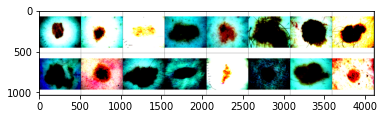

In [ ]:
# Show the original images
ins = torchvision.utils.make_grid(inputs)
imshow(ins)

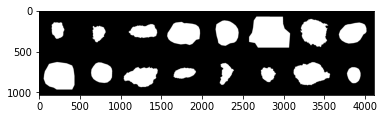

In [ ]:
# Show the corresponding segmentation masks
out = torchvision.utils.make_grid(masks)
imshow(out)


### *Train*

In [ ]:
# Global parameters (same for all training procedures for U-Net)
LEARNING_RATE = 1e-5 # Base learning rate, this worked best in previous experiements
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs 
N_CHANNELS = 3 # number of input channels
N_CLASSES = 1 # 1 object to be detected => skin lesion
LR_PATIENCE = 5 # If the loss does not improve after 5 epochs reduce the learning rate 
ES_PATIENCE = 10  # If the validation dice does not improve for this much epochs stop training 

#### With BCE Loss 

##### With SGD optimizer

In [ ]:
# Parameters
CHECKPOINT_UNET_BCE_SGD = '/content/drive/MyDrive/models/unet_BCE_SGD_aug.pth' # save model to this file
MOMENTUM = 0.9 # Momentum parameter for the optimizer

In [ ]:
# create a new U-Net model
unet_bce_sgd = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.SGD(unet_bce_sgd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_bce_sgd, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 300img [00:18, 16.49img/s, dice =0.242, loss =14.1]


Initial val dice: 0.1773, Initial val loss: 0.7420


In [ ]:
train_net(unet_bce_sgd, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_UNET_BCE_SGD, # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 3000img [05:22,  9.29img/s, loss (batch)=0.578]


Training Loss: 0.65783


Valid: 300img [00:20, 14.80img/s, dice =0.297, loss =12.9]


Val Dice: 0.2450, Val Loss: 0.6779




Epoch 2/100: 3000img [05:36,  8.92img/s, loss (batch)=0.484]


Training Loss: 0.57049


Valid: 300img [00:20, 14.77img/s, dice =0.306, loss =11.5]


Val Dice: 0.2611, Val Loss: 0.6052




Epoch 3/100: 3000img [05:37,  8.89img/s, loss (batch)=0.473]


Training Loss: 0.52441


Valid: 300img [00:20, 14.76img/s, dice =0.313, loss =11.3]


Val Dice: 0.2718, Val Loss: 0.5934




Epoch 4/100: 3000img [05:35,  8.93img/s, loss (batch)=0.442]


Training Loss: 0.49178


Valid: 300img [00:20, 14.79img/s, dice =0.318, loss =10.6]


Val Dice: 0.2799, Val Loss: 0.5600




Epoch 5/100: 3000img [05:35,  8.94img/s, loss (batch)=0.5]


Training Loss: 0.46773


Valid: 300img [00:20, 14.83img/s, dice =0.322, loss =10]


Val Dice: 0.2873, Val Loss: 0.5274




Epoch 6/100: 3000img [05:36,  8.90img/s, loss (batch)=0.446]


Training Loss: 0.44665


Valid: 300img [00:20, 14.68img/s, dice =0.329, loss =9.45]


Val Dice: 0.2957, Val Loss: 0.4973




Epoch 7/100: 3000img [05:37,  8.90img/s, loss (batch)=0.42]


Training Loss: 0.43060


Valid: 300img [00:20, 14.85img/s, dice =0.328, loss =9.16]


Val Dice: 0.2986, Val Loss: 0.4820




Epoch 8/100: 3000img [05:36,  8.92img/s, loss (batch)=0.342]


Training Loss: 0.41708


Valid: 300img [00:20, 14.85img/s, dice =0.33, loss =8.21]


Val Dice: 0.3043, Val Loss: 0.4323




Epoch 9/100: 3000img [05:36,  8.93img/s, loss (batch)=0.377]


Training Loss: 0.40085


Valid: 300img [00:20, 14.80img/s, dice =0.335, loss =8.71]


Val Dice: 0.3091, Val Loss: 0.4583




Epoch 10/100: 3000img [05:37,  8.89img/s, loss (batch)=0.459]


Training Loss: 0.39124


Valid: 300img [00:20, 14.81img/s, dice =0.336, loss =8.15]


Val Dice: 0.3136, Val Loss: 0.4290




Epoch 11/100: 3000img [05:37,  8.89img/s, loss (batch)=0.402]


Training Loss: 0.38156


Valid: 300img [00:20, 14.83img/s, dice =0.337, loss =7.89]


Val Dice: 0.3172, Val Loss: 0.4151




Epoch 12/100: 3000img [05:37,  8.90img/s, loss (batch)=0.304]


Training Loss: 0.37393


Valid: 300img [00:20, 14.79img/s, dice =0.346, loss =8.46]


Val Dice: 0.3213, Val Loss: 0.4454




Epoch 13/100: 3000img [05:36,  8.92img/s, loss (batch)=0.35]


Training Loss: 0.36700


Valid: 300img [00:20, 14.84img/s, dice =0.344, loss =7.66]


Val Dice: 0.3247, Val Loss: 0.4030




Epoch 14/100: 3000img [05:35,  8.93img/s, loss (batch)=0.322]


Training Loss: 0.35715


Valid: 300img [00:20, 14.86img/s, dice =0.352, loss =7.86]


Val Dice: 0.3308, Val Loss: 0.4136




Epoch 15/100: 3000img [05:36,  8.92img/s, loss (batch)=0.379]


Training Loss: 0.35014


Valid: 300img [00:20, 14.74img/s, dice =0.346, loss =7.12]


Val Dice: 0.3330, Val Loss: 0.3748




Epoch 16/100: 3000img [05:37,  8.90img/s, loss (batch)=0.315]


Training Loss: 0.34584


Valid: 300img [00:20, 14.80img/s, dice =0.347, loss =6.9]


Val Dice: 0.3357, Val Loss: 0.3634




Epoch 17/100: 3000img [05:36,  8.93img/s, loss (batch)=0.345]


Training Loss: 0.34103


Valid: 300img [00:20, 14.86img/s, dice =0.348, loss =6.79]


Val Dice: 0.3378, Val Loss: 0.3575




Epoch 18/100: 3000img [05:36,  8.93img/s, loss (batch)=0.264]


Training Loss: 0.33501


Valid: 300img [00:20, 14.85img/s, dice =0.349, loss =6.49]


Val Dice: 0.3423, Val Loss: 0.3415




Epoch 19/100: 3000img [05:36,  8.91img/s, loss (batch)=0.336]


Training Loss: 0.33092


Valid: 300img [00:20, 14.74img/s, dice =0.35, loss =6.44]


Val Dice: 0.3455, Val Loss: 0.3390




Epoch 20/100: 3000img [05:37,  8.90img/s, loss (batch)=0.277]


Training Loss: 0.32529


Valid: 300img [00:20, 14.79img/s, dice =0.353, loss =6.46]


Val Dice: 0.3475, Val Loss: 0.3399




Epoch 21/100: 3000img [05:37,  8.89img/s, loss (batch)=0.278]


Training Loss: 0.32251


Valid: 300img [00:20, 14.77img/s, dice =0.364, loss =7.11]


Val Dice: 0.3513, Val Loss: 0.3743




Epoch 22/100: 3000img [05:37,  8.89img/s, loss (batch)=0.325]


Training Loss: 0.31831


Valid: 300img [00:20, 14.79img/s, dice =0.359, loss =6.33]


Val Dice: 0.3535, Val Loss: 0.3331




Epoch 23/100: 3000img [05:37,  8.90img/s, loss (batch)=0.254]


Training Loss: 0.31534


Valid: 300img [00:20, 14.81img/s, dice =0.356, loss =6.11]


Val Dice: 0.3528, Val Loss: 0.3215




Epoch 24/100: 3000img [05:36,  8.91img/s, loss (batch)=0.223]


Training Loss: 0.31377


Valid: 300img [00:20, 14.82img/s, dice =0.36, loss =6.24]


Val Dice: 0.3574, Val Loss: 0.3286




Epoch 25/100: 3000img [05:36,  8.92img/s, loss (batch)=0.303]


Training Loss: 0.31100


Valid: 300img [00:20, 14.82img/s, dice =0.362, loss =6.06]


Val Dice: 0.3619, Val Loss: 0.3187




Epoch 26/100: 3000img [05:36,  8.93img/s, loss (batch)=0.268]


Training Loss: 0.30765


Valid: 300img [00:20, 14.84img/s, dice =0.363, loss =6.15]


Val Dice: 0.3592, Val Loss: 0.3235




Epoch 27/100: 3000img [05:37,  8.89img/s, loss (batch)=0.268]


Training Loss: 0.30705


Valid: 300img [00:20, 14.85img/s, dice =0.358, loss =6.03]


Val Dice: 0.3588, Val Loss: 0.3173




Epoch 28/100: 3000img [05:36,  8.92img/s, loss (batch)=0.267]


Training Loss: 0.30259


Valid: 300img [00:20, 14.87img/s, dice =0.373, loss =6.4]


Val Dice: 0.3641, Val Loss: 0.3371




Epoch 29/100: 3000img [05:35,  8.93img/s, loss (batch)=0.307]


Training Loss: 0.30502


Valid: 300img [00:20, 14.84img/s, dice =0.369, loss =5.97]


Val Dice: 0.3670, Val Loss: 0.3143




Epoch 30/100: 3000img [05:36,  8.92img/s, loss (batch)=0.204]


Training Loss: 0.30100


Valid: 300img [00:20, 14.80img/s, dice =0.363, loss =5.93]


Val Dice: 0.3640, Val Loss: 0.3123




Epoch 31/100: 3000img [05:36,  8.91img/s, loss (batch)=0.246]


Training Loss: 0.29865


Valid: 300img [00:20, 14.78img/s, dice =0.359, loss =5.48]


Val Dice: 0.3686, Val Loss: 0.2882




Epoch 32/100: 3000img [05:36,  8.91img/s, loss (batch)=0.285]


Training Loss: 0.29570


Valid: 300img [00:20, 14.78img/s, dice =0.366, loss =5.65]


Val Dice: 0.3714, Val Loss: 0.2971




Epoch 33/100: 3000img [05:37,  8.90img/s, loss (batch)=0.199]


Training Loss: 0.29635


Valid: 300img [00:20, 14.76img/s, dice =0.373, loss =6.06]


Val Dice: 0.3690, Val Loss: 0.3191




Epoch 34/100: 3000img [05:37,  8.89img/s, loss (batch)=0.199]


Training Loss: 0.29441


Valid: 300img [00:20, 14.83img/s, dice =0.371, loss =6.03]


Val Dice: 0.3706, Val Loss: 0.3176




Epoch 35/100: 3000img [05:37,  8.90img/s, loss (batch)=0.241]


Training Loss: 0.29157


Valid: 300img [00:20, 14.85img/s, dice =0.365, loss =5.63]


Val Dice: 0.3703, Val Loss: 0.2965




Epoch 36/100: 3000img [05:36,  8.93img/s, loss (batch)=0.245]


Training Loss: 0.29005


Valid: 300img [00:20, 14.82img/s, dice =0.375, loss =5.89]


Val Dice: 0.3770, Val Loss: 0.3098




Epoch 37/100: 3000img [05:36,  8.92img/s, loss (batch)=0.28]


Training Loss: 0.28832


Valid: 300img [00:20, 14.87img/s, dice =0.371, loss =5.62]


Val Dice: 0.3752, Val Loss: 0.2958




Epoch 38/100: 3000img [05:37,  8.89img/s, loss (batch)=0.274]


Training Loss: 0.28743


Valid: 300img [00:20, 14.76img/s, dice =0.378, loss =5.8]


Val Dice: 0.3753, Val Loss: 0.3053




Epoch 39/100: 3000img [05:36,  8.91img/s, loss (batch)=0.314]


Training Loss: 0.28874


Valid: 300img [00:20, 14.87img/s, dice =0.372, loss =5.7]


Val Dice: 0.3741, Val Loss: 0.2999




Epoch 40/100: 3000img [05:34,  8.96img/s, loss (batch)=0.466]


Training Loss: 0.28802


Valid: 300img [00:20, 14.84img/s, dice =0.361, loss =5.23]


Val Dice: 0.3782, Val Loss: 0.2754




Epoch 41/100: 3000img [05:35,  8.94img/s, loss (batch)=0.243]


Training Loss: 0.28765


Valid: 300img [00:20, 14.80img/s, dice =0.364, loss =5.51]


Val Dice: 0.3755, Val Loss: 0.2899




Epoch 42/100: 3000img [05:36,  8.91img/s, loss (batch)=0.246]


Training Loss: 0.28845


Valid: 300img [00:20, 14.84img/s, dice =0.375, loss =5.78]


Val Dice: 0.3773, Val Loss: 0.3041




Epoch 43/100: 3000img [05:36,  8.92img/s, loss (batch)=0.277]


Training Loss: 0.28867


Valid: 300img [00:20, 14.81img/s, dice =0.373, loss =5.72]


Val Dice: 0.3758, Val Loss: 0.3008




Epoch 44/100: 3000img [05:36,  8.91img/s, loss (batch)=0.275]


Training Loss: 0.28953


Valid: 300img [00:20, 14.79img/s, dice =0.368, loss =5.55]


Val Dice: 0.3771, Val Loss: 0.2920




Epoch 45/100: 3000img [05:36,  8.91img/s, loss (batch)=0.383]


Training Loss: 0.28801


Valid: 300img [00:20, 14.79img/s, dice =0.375, loss =5.71]


Val Dice: 0.3775, Val Loss: 0.3003




Epoch 46/100: 3000img [05:36,  8.90img/s, loss (batch)=0.296]


Training Loss: 0.28887


Valid: 300img [00:20, 14.88img/s, dice =0.376, loss =5.7]


Val Dice: 0.3791, Val Loss: 0.2999




Epoch 47/100: 3000img [05:35,  8.95img/s, loss (batch)=0.242]


Training Loss: 0.28824


Valid: 300img [00:20, 14.86img/s, dice =0.372, loss =5.55]


Val Dice: 0.3783, Val Loss: 0.2920




Epoch 48/100: 3000img [05:35,  8.94img/s, loss (batch)=0.273]


Training Loss: 0.28818


Valid: 300img [00:20, 14.81img/s, dice =0.371, loss =5.53]


Val Dice: 0.3795, Val Loss: 0.2910




Epoch 49/100: 3000img [05:36,  8.92img/s, loss (batch)=0.249]


Training Loss: 0.28867


Valid: 300img [00:20, 14.84img/s, dice =0.374, loss =5.58]


Val Dice: 0.3786, Val Loss: 0.2936




Epoch 50/100: 3000img [05:36,  8.93img/s, loss (batch)=0.307]


Training Loss: 0.28768


Valid: 300img [00:20, 14.83img/s, dice =0.382, loss =5.88]


Val Dice: 0.3791, Val Loss: 0.3094




Epoch 51/100: 3000img [05:34,  8.97img/s, loss (batch)=0.262]


Training Loss: 0.28606


Valid: 300img [00:20, 14.92img/s, dice =0.371, loss =5.65]


Val Dice: 0.3749, Val Loss: 0.2975




Epoch 52/100: 3000img [05:34,  8.96img/s, loss (batch)=0.262]


Training Loss: 0.28645


Valid: 300img [00:20, 14.85img/s, dice =0.378, loss =6.05]


Val Dice: 0.3742, Val Loss: 0.3182




Epoch 53/100: 3000img [05:36,  8.91img/s, loss (batch)=0.281]


Training Loss: 0.28748


Valid: 300img [00:20, 14.81img/s, dice =0.368, loss =5.52]


Val Dice: 0.3787, Val Loss: 0.2906




Epoch 54/100: 3000img [05:36,  8.92img/s, loss (batch)=0.303]


Training Loss: 0.28799


Valid: 300img [00:20, 14.83img/s, dice =0.381, loss =6.02]


Val Dice: 0.3769, Val Loss: 0.3167




Epoch 55/100: 3000img [05:36,  8.93img/s, loss (batch)=0.207]


Training Loss: 0.28784


Valid: 300img [00:20, 14.84img/s, dice =0.373, loss =5.57]


Val Dice: 0.3774, Val Loss: 0.2930




Epoch 56/100: 3000img [05:35,  8.93img/s, loss (batch)=0.219]


Training Loss: 0.28711


Valid: 300img [00:20, 14.81img/s, dice =0.373, loss =5.79]


Val Dice: 0.3760, Val Loss: 0.3046




Epoch 57/100: 3000img [05:36,  8.92img/s, loss (batch)=0.35]


Training Loss: 0.28752


Valid: 300img [00:20, 14.77img/s, dice =0.379, loss =5.72]


Val Dice: 0.3766, Val Loss: 0.3008




Epoch 58/100: 3000img [05:36,  8.93img/s, loss (batch)=0.25]


Training Loss: 0.28706


Valid: 300img [00:20, 14.81img/s, dice =0.37, loss =5.62]


Val Dice: 0.3780, Val Loss: 0.2956




Epoch 59/100: 3000img [05:35,  8.94img/s, loss (batch)=0.317]


Training Loss: 0.28743


Valid: 300img [00:20, 14.86img/s, dice =0.377, loss =6.04]


Val Dice: 0.3762, Val Loss: 0.3181
EARLY STOPPING AFTER 59 EPOCHS


==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
unet_bce_sgd.load_state_dict(torch.load(CHECKPOINT_UNET_BCE_SGD))
unet_bce_sgd.eval()

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, unet_bce_sgd, threshold= th, device=DEVICE)

In [59]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.3232   |  0.3745   |
|  2        |  0.2035   |  0.9507   |
|  3        |  0.3227   |  0.373    |
|  4        |  0.3645   |  0.5924   |
|  5        |  0.1078   |  0.0      |
|  6        |  0.3698   |  0.7096   |
|  7        |  0.3699   |  0.657    |
|  8        |  0.3532   |  0.5112   |
|  9        |  0.3703   |  0.686    |
|  10       |  0.3702   |  0.6958   |
|  11       |  0.3703   |  0.6747   |
|  12       |  0.3703   |  0.6815   |


In [60]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_bce_sgd = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_bce_sgd:.4f}")

The optimal threshold is 0.6860


##### With ADAM optimizer

In [ ]:
# Parameters 
CHECKPOINT_UNET_BCE_ADAM = '/content/drive/MyDrive/models/unet_BCE_ADAM_aug.pth' # save model to this file
WEIGHT_DECAY = 1e-8 #weight decay parameter of ADAM optimizer

In [ ]:
# create a new U-Net model
unet_bce_adam = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(unet_bce_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_bce_adam, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 300img [00:20, 14.87img/s, dice =0.237, loss =12.8]


Initial val dice: 0.1751, Initial val loss: 0.6725


In [ ]:
train_net(unet_bce_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_UNET_BCE_ADAM, # where to save the model
          True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 3000img [05:39,  8.84img/s, loss (batch)=0.271]


Training Loss: 0.39782


Valid: 300img [00:20, 14.85img/s, dice =0.371, loss =5.97]


Val Dice: 0.3443, Val Loss: 0.3144




Epoch 2/100: 3000img [05:38,  8.87img/s, loss (batch)=0.254]


Training Loss: 0.29497


Valid: 300img [00:20, 14.92img/s, dice =0.446, loss =6.12]


Val Dice: 0.4085, Val Loss: 0.3219




Epoch 3/100: 3000img [05:37,  8.89img/s, loss (batch)=0.341]


Training Loss: 0.26228


Valid: 300img [00:20, 14.87img/s, dice =0.473, loss =5.26]


Val Dice: 0.4269, Val Loss: 0.2767




Epoch 4/100: 3000img [05:37,  8.88img/s, loss (batch)=0.327]


Training Loss: 0.24472


Valid: 300img [00:20, 14.84img/s, dice =0.49, loss =4.73]


Val Dice: 0.4479, Val Loss: 0.2489




Epoch 5/100: 3000img [05:38,  8.87img/s, loss (batch)=0.333]


Training Loss: 0.23107


Valid: 300img [00:20, 14.92img/s, dice =0.521, loss =4.57]


Val Dice: 0.4578, Val Loss: 0.2406




Epoch 6/100: 3000img [05:36,  8.92img/s, loss (batch)=0.192]


Training Loss: 0.21918


Valid: 300img [00:20, 14.97img/s, dice =0.526, loss =4.4]


Val Dice: 0.4663, Val Loss: 0.2315




Epoch 7/100: 3000img [05:36,  8.91img/s, loss (batch)=0.206]


Training Loss: 0.20619


Valid: 300img [00:20, 14.93img/s, dice =0.546, loss =3.99]


Val Dice: 0.4887, Val Loss: 0.2098




Epoch 8/100: 3000img [05:38,  8.86img/s, loss (batch)=0.2]


Training Loss: 0.19728


Valid: 300img [00:20, 14.87img/s, dice =0.535, loss =3.95]


Val Dice: 0.5005, Val Loss: 0.2080




Epoch 9/100: 3000img [05:38,  8.86img/s, loss (batch)=0.189]


Training Loss: 0.18890


Valid: 300img [00:20, 14.86img/s, dice =0.539, loss =4.14]


Val Dice: 0.4987, Val Loss: 0.2176




Epoch 10/100: 3000img [05:38,  8.86img/s, loss (batch)=0.155]


Training Loss: 0.18120


Valid: 300img [00:20, 14.86img/s, dice =0.54, loss =3.79]


Val Dice: 0.5171, Val Loss: 0.1992




Epoch 11/100: 3000img [05:37,  8.89img/s, loss (batch)=0.331]


Training Loss: 0.17365


Valid: 300img [00:20, 15.00img/s, dice =0.551, loss =3.54]


Val Dice: 0.5257, Val Loss: 0.1862




Epoch 12/100: 3000img [05:36,  8.91img/s, loss (batch)=0.175]


Training Loss: 0.16617


Valid: 300img [00:20, 14.89img/s, dice =0.605, loss =3.65]


Val Dice: 0.5202, Val Loss: 0.1919




Epoch 13/100: 3000img [05:36,  8.90img/s, loss (batch)=0.213]


Training Loss: 0.16131


Valid: 300img [00:20, 14.87img/s, dice =0.601, loss =3.48]


Val Dice: 0.5486, Val Loss: 0.1832




Epoch 14/100: 3000img [05:38,  8.87img/s, loss (batch)=0.172]


Training Loss: 0.15523


Valid: 300img [00:20, 14.87img/s, dice =0.591, loss =3.17]


Val Dice: 0.5653, Val Loss: 0.1670




Epoch 15/100: 3000img [05:37,  8.88img/s, loss (batch)=0.174]


Training Loss: 0.14839


Valid: 300img [00:20, 14.90img/s, dice =0.575, loss =3.12]


Val Dice: 0.5630, Val Loss: 0.1644




Epoch 16/100: 3000img [05:37,  8.89img/s, loss (batch)=0.121]


Training Loss: 0.14315


Valid: 300img [00:20, 14.88img/s, dice =0.589, loss =3.06]


Val Dice: 0.5731, Val Loss: 0.1609




Epoch 17/100: 3000img [05:38,  8.86img/s, loss (batch)=0.125]


Training Loss: 0.13804


Valid: 300img [00:20, 14.87img/s, dice =0.63, loss =3.06]


Val Dice: 0.5801, Val Loss: 0.1611




Epoch 18/100: 3000img [05:38,  8.87img/s, loss (batch)=0.117]


Training Loss: 0.13246


Valid: 300img [00:20, 14.88img/s, dice =0.62, loss =3.01]


Val Dice: 0.5957, Val Loss: 0.1582




Epoch 19/100: 3000img [05:38,  8.87img/s, loss (batch)=0.152]


Training Loss: 0.12967


Valid: 300img [00:20, 14.82img/s, dice =0.628, loss =2.74]


Val Dice: 0.6013, Val Loss: 0.1443




Epoch 20/100: 3000img [05:36,  8.92img/s, loss (batch)=0.167]


Training Loss: 0.12353


Valid: 300img [00:20, 14.99img/s, dice =0.634, loss =2.73]


Val Dice: 0.6205, Val Loss: 0.1436




Epoch 21/100: 3000img [05:36,  8.93img/s, loss (batch)=0.127]


Training Loss: 0.11965


Valid: 300img [00:20, 14.91img/s, dice =0.642, loss =2.64]


Val Dice: 0.6279, Val Loss: 0.1387




Epoch 22/100: 3000img [05:36,  8.92img/s, loss (batch)=0.0845]


Training Loss: 0.11744


Valid: 300img [00:20, 14.90img/s, dice =0.647, loss =2.79]


Val Dice: 0.6176, Val Loss: 0.1471




Epoch 23/100: 3000img [05:36,  8.92img/s, loss (batch)=0.113]


Training Loss: 0.11257


Valid: 300img [00:20, 14.98img/s, dice =0.649, loss =2.61]


Val Dice: 0.6333, Val Loss: 0.1372




Epoch 24/100: 3000img [05:36,  8.91img/s, loss (batch)=0.0984]


Training Loss: 0.10868


Valid: 300img [00:20, 14.92img/s, dice =0.672, loss =2.91]


Val Dice: 0.6305, Val Loss: 0.1530




Epoch 25/100: 3000img [05:36,  8.91img/s, loss (batch)=0.0859]


Training Loss: 0.10641


Valid: 300img [00:20, 14.85img/s, dice =0.715, loss =2.71]


Val Dice: 0.6558, Val Loss: 0.1427




Epoch 26/100: 3000img [05:36,  8.90img/s, loss (batch)=0.0921]


Training Loss: 0.10457


Valid: 300img [00:20, 14.90img/s, dice =0.651, loss =2.61]


Val Dice: 0.6591, Val Loss: 0.1375




Epoch 27/100: 3000img [05:36,  8.92img/s, loss (batch)=0.12]


Training Loss: 0.10080


Valid: 300img [00:20, 14.87img/s, dice =0.692, loss =2.71]


Val Dice: 0.6432, Val Loss: 0.1424




Epoch 28/100: 3000img [05:36,  8.91img/s, loss (batch)=0.0823]


Training Loss: 0.09639


Valid: 300img [00:20, 14.86img/s, dice =0.694, loss =2.68]


Val Dice: 0.6571, Val Loss: 0.1410




Epoch 29/100: 3000img [05:36,  8.91img/s, loss (batch)=0.0872]


Training Loss: 0.09508


Valid: 300img [00:20, 14.91img/s, dice =0.731, loss =2.51]


Val Dice: 0.6681, Val Loss: 0.1322




Epoch 30/100: 3000img [05:35,  8.94img/s, loss (batch)=0.128]


Training Loss: 0.09051


Valid: 300img [00:20, 14.87img/s, dice =0.678, loss =2.83]


Val Dice: 0.6723, Val Loss: 0.1488




Epoch 31/100: 3000img [05:35,  8.94img/s, loss (batch)=0.0782]


Training Loss: 0.08894


Valid: 300img [00:20, 14.89img/s, dice =0.684, loss =2.75]


Val Dice: 0.6768, Val Loss: 0.1448




Epoch 32/100: 3000img [05:35,  8.94img/s, loss (batch)=0.0767]


Training Loss: 0.08662


Valid: 300img [00:20, 14.91img/s, dice =0.71, loss =2.61]


Val Dice: 0.6836, Val Loss: 0.1372




Epoch 33/100: 3000img [05:35,  8.94img/s, loss (batch)=0.0836]


Training Loss: 0.08565


Valid: 300img [00:20, 14.92img/s, dice =0.727, loss =2.62]


Val Dice: 0.6866, Val Loss: 0.1381




Epoch 34/100: 3000img [05:36,  8.92img/s, loss (batch)=0.107]


Training Loss: 0.08485


Valid: 300img [00:20, 14.84img/s, dice =0.694, loss =2.32]


Val Dice: 0.7048, Val Loss: 0.1219




Epoch 35/100: 3000img [05:36,  8.92img/s, loss (batch)=0.0566]


Training Loss: 0.08001


Valid: 300img [00:20, 14.85img/s, dice =0.728, loss =2.33]


Val Dice: 0.7131, Val Loss: 0.1225




Epoch 36/100: 3000img [05:36,  8.92img/s, loss (batch)=0.0616]


Training Loss: 0.07848


Valid: 300img [00:20, 14.84img/s, dice =0.689, loss =2.46]


Val Dice: 0.6991, Val Loss: 0.1297




Epoch 37/100: 3000img [05:37,  8.89img/s, loss (batch)=0.0771]


Training Loss: 0.07798


Valid: 300img [00:20, 14.87img/s, dice =0.732, loss =2.41]


Val Dice: 0.7075, Val Loss: 0.1267




Epoch 38/100: 3000img [05:36,  8.93img/s, loss (batch)=0.0476]


Training Loss: 0.07398


Valid: 300img [00:20, 14.96img/s, dice =0.726, loss =2.28]


Val Dice: 0.7127, Val Loss: 0.1200




Epoch 39/100: 3000img [05:35,  8.93img/s, loss (batch)=0.107]


Training Loss: 0.07189


Valid: 300img [00:19, 15.01img/s, dice =0.748, loss =2.34]


Val Dice: 0.7246, Val Loss: 0.1234




Epoch 40/100: 3000img [05:36,  8.93img/s, loss (batch)=0.0737]


Training Loss: 0.07142


Valid: 300img [00:20, 14.91img/s, dice =0.758, loss =2.41]


Val Dice: 0.7187, Val Loss: 0.1267




Epoch 41/100: 3000img [05:35,  8.93img/s, loss (batch)=0.0427]


Training Loss: 0.07114


Valid: 300img [00:20, 14.97img/s, dice =0.732, loss =2.44]


Val Dice: 0.7155, Val Loss: 0.1286




Epoch 42/100: 3000img [05:34,  8.96img/s, loss (batch)=0.0502]


Training Loss: 0.06914


Valid: 300img [00:20, 14.91img/s, dice =0.721, loss =2.46]


Val Dice: 0.7334, Val Loss: 0.1295




Epoch 43/100: 3000img [05:35,  8.93img/s, loss (batch)=0.0774]


Training Loss: 0.06532


Valid: 300img [00:20, 14.84img/s, dice =0.748, loss =2.34]


Val Dice: 0.7362, Val Loss: 0.1231




Epoch 44/100: 3000img [05:36,  8.93img/s, loss (batch)=0.0478]


Training Loss: 0.06453


Valid: 300img [00:20, 14.85img/s, dice =0.715, loss =2.3]


Val Dice: 0.7359, Val Loss: 0.1209




Epoch 45/100: 3000img [05:35,  8.94img/s, loss (batch)=0.0538]


Training Loss: 0.05661


Valid: 300img [00:20, 14.92img/s, dice =0.75, loss =2.45]


Val Dice: 0.7380, Val Loss: 0.1292




Epoch 46/100: 3000img [05:35,  8.94img/s, loss (batch)=0.0521]


Training Loss: 0.05349


Valid: 300img [00:20, 14.85img/s, dice =0.748, loss =2.44]


Val Dice: 0.7468, Val Loss: 0.1282




Epoch 47/100: 3000img [05:35,  8.94img/s, loss (batch)=0.0475]


Training Loss: 0.05238


Valid: 300img [00:20, 14.89img/s, dice =0.758, loss =2.5]


Val Dice: 0.7432, Val Loss: 0.1314




Epoch 48/100: 3000img [05:36,  8.91img/s, loss (batch)=0.0644]


Training Loss: 0.05204


Valid: 300img [00:20, 14.88img/s, dice =0.76, loss =2.46]


Val Dice: 0.7465, Val Loss: 0.1294




Epoch 49/100: 3000img [05:36,  8.91img/s, loss (batch)=0.0506]


Training Loss: 0.05198


Valid: 300img [00:20, 14.89img/s, dice =0.753, loss =2.49]


Val Dice: 0.7473, Val Loss: 0.1311




Epoch 50/100: 3000img [05:36,  8.92img/s, loss (batch)=0.0606]


Training Loss: 0.05153


Valid: 300img [00:20, 14.99img/s, dice =0.763, loss =2.43]


Val Dice: 0.7501, Val Loss: 0.1279




Epoch 51/100: 3000img [05:35,  8.93img/s, loss (batch)=0.0355]


Training Loss: 0.05056


Valid: 300img [00:20, 14.97img/s, dice =0.766, loss =2.37]


Val Dice: 0.7572, Val Loss: 0.1245




Epoch 52/100: 3000img [05:35,  8.93img/s, loss (batch)=0.0432]


Training Loss: 0.05035


Valid: 300img [00:20, 14.86img/s, dice =0.75, loss =2.5]


Val Dice: 0.7493, Val Loss: 0.1316




Epoch 53/100: 3000img [05:35,  8.93img/s, loss (batch)=0.0487]


Training Loss: 0.04990


Valid: 300img [00:20, 14.91img/s, dice =0.754, loss =2.48]


Val Dice: 0.7493, Val Loss: 0.1307




Epoch 54/100: 3000img [05:36,  8.92img/s, loss (batch)=0.0435]


Training Loss: 0.04953


Valid: 300img [00:20, 14.90img/s, dice =0.759, loss =2.4]


Val Dice: 0.7528, Val Loss: 0.1261




Epoch 55/100: 3000img [05:37,  8.89img/s, loss (batch)=0.0438]


Training Loss: 0.04945


Valid: 300img [00:20, 14.88img/s, dice =0.761, loss =2.44]


Val Dice: 0.7507, Val Loss: 0.1282




Epoch 56/100: 3000img [05:37,  8.89img/s, loss (batch)=0.054]


Training Loss: 0.04915


Valid: 300img [00:20, 14.88img/s, dice =0.762, loss =2.47]


Val Dice: 0.7522, Val Loss: 0.1300




Epoch 57/100: 3000img [05:37,  8.90img/s, loss (batch)=0.0458]


Training Loss: 0.04957


Valid: 300img [00:20, 14.88img/s, dice =0.751, loss =2.54]


Val Dice: 0.7496, Val Loss: 0.1336




Epoch 58/100: 3000img [05:36,  8.90img/s, loss (batch)=0.0488]


Training Loss: 0.04930


Valid: 300img [00:20, 14.87img/s, dice =0.753, loss =2.5]


Val Dice: 0.7503, Val Loss: 0.1316




Epoch 59/100: 3000img [05:37,  8.89img/s, loss (batch)=0.0656]


Training Loss: 0.04930


Valid: 300img [00:20, 14.92img/s, dice =0.761, loss =2.44]


Val Dice: 0.7534, Val Loss: 0.1287




Epoch 60/100: 3000img [05:36,  8.92img/s, loss (batch)=0.0455]


Training Loss: 0.04982


Valid: 300img [00:20, 14.86img/s, dice =0.758, loss =2.48]


Val Dice: 0.7517, Val Loss: 0.1305




Epoch 61/100: 3000img [05:36,  8.92img/s, loss (batch)=0.0422]


Training Loss: 0.04997


Valid: 300img [00:20, 14.91img/s, dice =0.757, loss =2.48]


Val Dice: 0.7473, Val Loss: 0.1305




Epoch 62/100: 3000img [05:36,  8.92img/s, loss (batch)=0.049]


Training Loss: 0.04989


Valid: 300img [00:20, 14.87img/s, dice =0.759, loss =2.44]


Val Dice: 0.7521, Val Loss: 0.1286
EARLY STOPPING AFTER 62 EPOCHS


==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
unet_bce_adam.load_state_dict(torch.load(CHECKPOINT_UNET_BCE_ADAM))
unet_bce_adam.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, unet_bce_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6706   |  0.3745   |
|  2        |  0.6438   |  0.9507   |
|  3        |  0.6704   |  0.373    |
|  4        |  0.6843   |  0.5636   |
|  5        |  0.1078   |  0.0      |
|  6        |  0.6852   |  0.7606   |
|  7        |  0.6868   |  0.6649   |
|  8        |  0.6776   |  0.8497   |
|  9        |  0.6797   |  0.4799   |
|  10       |  0.6861   |  0.6179   |
|  11       |  0.6866   |  0.7128   |
|  12       |  0.6869   |  0.6884   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_bce_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_bce_adam:.4f}")

The optimal threshold is 0.6884


#### With DiceBCE Loss 

##### With SGD optimizer

In [ ]:
# Parameters
CHECKPOINT_UNET_DiceBCE_SGD = '/content/drive/MyDrive/models/unet_DiceBCE_SGD_aug.pth' # save model to this file
MOMENTUM = 0.9 # Momentum parameter for the optimizer

In [ ]:
# create a new U-Net model
unet_dicebce_sgd = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.SGD(unet_dicebce_sgd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_dicebce_sgd, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 300img [00:16, 17.65img/s, dice =0.237, loss =28.6]


Initial val dice: 0.1747, Initial val loss: 1.5033


In [ ]:
train_net(unet_dicebce_sgd, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_UNET_DiceBCE_SGD, # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 3000img [08:11,  6.11img/s, loss (batch)=1.14]


Training Loss: 1.21185


Valid: 300img [00:16, 18.08img/s, dice =0.312, loss =25.3]


Val Dice: 0.2595, Val Loss: 1.3326




Epoch 2/100: 3000img [08:10,  6.11img/s, loss (batch)=1.06]


Training Loss: 1.09882


Valid: 300img [00:16, 18.11img/s, dice =0.325, loss =24.3]


Val Dice: 0.2761, Val Loss: 1.2785




Epoch 3/100: 3000img [08:10,  6.11img/s, loss (batch)=0.883]


Training Loss: 1.03906


Valid: 300img [00:16, 18.14img/s, dice =0.333, loss =23.3]


Val Dice: 0.2900, Val Loss: 1.2247




Epoch 4/100: 3000img [08:10,  6.11img/s, loss (batch)=1.04]


Training Loss: 1.00062


Valid: 300img [00:16, 18.10img/s, dice =0.34, loss =23.2]


Val Dice: 0.2986, Val Loss: 1.2192




Epoch 5/100: 3000img [08:10,  6.11img/s, loss (batch)=0.929]


Training Loss: 0.96546


Valid: 300img [00:16, 18.11img/s, dice =0.344, loss =22.4]


Val Dice: 0.3071, Val Loss: 1.1793




Epoch 6/100: 3000img [08:10,  6.11img/s, loss (batch)=0.904]


Training Loss: 0.93341


Valid: 300img [00:16, 18.15img/s, dice =0.353, loss =22.7]


Val Dice: 0.3141, Val Loss: 1.1938




Epoch 7/100: 3000img [08:10,  6.12img/s, loss (batch)=1.01]


Training Loss: 0.91515


Valid: 300img [00:16, 18.10img/s, dice =0.353, loss =21.8]


Val Dice: 0.3212, Val Loss: 1.1494




Epoch 8/100: 3000img [08:10,  6.12img/s, loss (batch)=0.884]


Training Loss: 0.89641


Valid: 300img [00:16, 18.15img/s, dice =0.357, loss =21]


Val Dice: 0.3275, Val Loss: 1.1062




Epoch 9/100: 3000img [08:10,  6.11img/s, loss (batch)=0.802]


Training Loss: 0.87831


Valid: 300img [00:16, 18.14img/s, dice =0.363, loss =21.2]


Val Dice: 0.3317, Val Loss: 1.1134




Epoch 10/100: 3000img [08:10,  6.11img/s, loss (batch)=0.762]


Training Loss: 0.85944


Valid: 300img [00:16, 18.12img/s, dice =0.359, loss =20.4]


Val Dice: 0.3395, Val Loss: 1.0729




Epoch 11/100: 3000img [08:10,  6.11img/s, loss (batch)=0.602]


Training Loss: 0.84603


Valid: 300img [00:16, 18.13img/s, dice =0.366, loss =20.2]


Val Dice: 0.3425, Val Loss: 1.0652




Epoch 12/100: 3000img [08:10,  6.12img/s, loss (batch)=0.825]


Training Loss: 0.83119


Valid: 300img [00:16, 18.12img/s, dice =0.365, loss =19.7]


Val Dice: 0.3493, Val Loss: 1.0391




Epoch 13/100: 3000img [08:10,  6.11img/s, loss (batch)=0.854]


Training Loss: 0.82233


Valid: 300img [00:16, 18.13img/s, dice =0.369, loss =19.9]


Val Dice: 0.3501, Val Loss: 1.0452




Epoch 14/100: 3000img [08:10,  6.12img/s, loss (batch)=0.799]


Training Loss: 0.81237


Valid: 300img [00:16, 18.12img/s, dice =0.373, loss =19.7]


Val Dice: 0.3550, Val Loss: 1.0373




Epoch 15/100: 3000img [08:10,  6.12img/s, loss (batch)=0.784]


Training Loss: 0.80184


Valid: 300img [00:16, 18.12img/s, dice =0.378, loss =20.1]


Val Dice: 0.3569, Val Loss: 1.0597




Epoch 16/100: 3000img [08:10,  6.12img/s, loss (batch)=0.805]


Training Loss: 0.79082


Valid: 300img [00:16, 18.13img/s, dice =0.387, loss =20.2]


Val Dice: 0.3608, Val Loss: 1.0631




Epoch 17/100: 3000img [08:10,  6.11img/s, loss (batch)=0.917]


Training Loss: 0.78348


Valid: 300img [00:16, 18.09img/s, dice =0.384, loss =19.3]


Val Dice: 0.3693, Val Loss: 1.0158




Epoch 18/100: 3000img [08:10,  6.12img/s, loss (batch)=0.8]


Training Loss: 0.77277


Valid: 300img [00:16, 18.14img/s, dice =0.38, loss =18.9]


Val Dice: 0.3720, Val Loss: 0.9962




Epoch 19/100: 3000img [08:10,  6.12img/s, loss (batch)=0.664]


Training Loss: 0.77000


Valid: 300img [00:16, 18.16img/s, dice =0.382, loss =18.7]


Val Dice: 0.3746, Val Loss: 0.9841




Epoch 20/100: 3000img [08:10,  6.12img/s, loss (batch)=0.861]


Training Loss: 0.76470


Valid: 300img [00:16, 18.10img/s, dice =0.395, loss =19]


Val Dice: 0.3787, Val Loss: 1.0021




Epoch 21/100: 3000img [08:10,  6.11img/s, loss (batch)=0.671]


Training Loss: 0.75620


Valid: 300img [00:16, 18.14img/s, dice =0.389, loss =18.9]


Val Dice: 0.3767, Val Loss: 0.9946




Epoch 22/100: 3000img [08:10,  6.12img/s, loss (batch)=0.83]


Training Loss: 0.75035


Valid: 300img [00:16, 18.14img/s, dice =0.385, loss =18.8]


Val Dice: 0.3784, Val Loss: 0.9881




Epoch 23/100: 3000img [08:10,  6.11img/s, loss (batch)=0.708]


Training Loss: 0.74636


Valid: 300img [00:16, 18.10img/s, dice =0.386, loss =17.9]


Val Dice: 0.3891, Val Loss: 0.9443




Epoch 24/100: 3000img [08:10,  6.12img/s, loss (batch)=0.544]


Training Loss: 0.73733


Valid: 300img [00:16, 18.13img/s, dice =0.398, loss =18.4]


Val Dice: 0.3874, Val Loss: 0.9705




Epoch 25/100: 3000img [08:10,  6.11img/s, loss (batch)=0.622]


Training Loss: 0.73719


Valid: 300img [00:16, 18.13img/s, dice =0.39, loss =18]


Val Dice: 0.3882, Val Loss: 0.9477




Epoch 26/100: 3000img [08:10,  6.12img/s, loss (batch)=0.755]


Training Loss: 0.73048


Valid: 300img [00:16, 18.14img/s, dice =0.391, loss =17.9]


Val Dice: 0.3923, Val Loss: 0.9432




Epoch 27/100: 3000img [08:10,  6.12img/s, loss (batch)=0.754]


Training Loss: 0.72234


Valid: 300img [00:16, 18.12img/s, dice =0.388, loss =17.3]


Val Dice: 0.3999, Val Loss: 0.9114




Epoch 28/100: 3000img [08:10,  6.12img/s, loss (batch)=0.689]


Training Loss: 0.71978


Valid: 300img [00:16, 18.10img/s, dice =0.401, loss =17.7]


Val Dice: 0.3988, Val Loss: 0.9291




Epoch 29/100: 3000img [08:10,  6.11img/s, loss (batch)=0.604]


Training Loss: 0.72092


Valid: 300img [00:16, 18.15img/s, dice =0.398, loss =17.5]


Val Dice: 0.4013, Val Loss: 0.9220




Epoch 30/100: 3000img [08:10,  6.12img/s, loss (batch)=0.582]


Training Loss: 0.71824


Valid: 300img [00:16, 18.14img/s, dice =0.389, loss =17.4]


Val Dice: 0.4005, Val Loss: 0.9175




Epoch 31/100: 3000img [08:10,  6.12img/s, loss (batch)=0.761]


Training Loss: 0.70998


Valid: 300img [00:16, 18.09img/s, dice =0.399, loss =17.6]


Val Dice: 0.4025, Val Loss: 0.9258




Epoch 32/100: 3000img [08:10,  6.12img/s, loss (batch)=0.547]


Training Loss: 0.71218


Valid: 300img [00:16, 18.13img/s, dice =0.403, loss =17.9]


Val Dice: 0.3998, Val Loss: 0.9419




Epoch 33/100: 3000img [08:10,  6.11img/s, loss (batch)=0.702]


Training Loss: 0.70140


Valid: 300img [00:16, 18.14img/s, dice =0.409, loss =17.8]


Val Dice: 0.4032, Val Loss: 0.9357




Epoch 34/100: 3000img [08:10,  6.12img/s, loss (batch)=0.523]


Training Loss: 0.70308


Valid: 300img [00:16, 18.09img/s, dice =0.405, loss =17.8]


Val Dice: 0.4027, Val Loss: 0.9353




Epoch 35/100: 3000img [08:10,  6.12img/s, loss (batch)=0.736]


Training Loss: 0.70503


Valid: 300img [00:16, 18.13img/s, dice =0.398, loss =17.3]


Val Dice: 0.4073, Val Loss: 0.9115




Epoch 36/100: 3000img [08:10,  6.12img/s, loss (batch)=0.454]


Training Loss: 0.70026


Valid: 300img [00:16, 18.12img/s, dice =0.404, loss =17.2]


Val Dice: 0.4089, Val Loss: 0.9068




Epoch 37/100: 3000img [08:10,  6.12img/s, loss (batch)=0.718]


Training Loss: 0.70231


Valid: 300img [00:16, 18.12img/s, dice =0.396, loss =17]


Val Dice: 0.4108, Val Loss: 0.8923




Epoch 38/100: 3000img [08:10,  6.12img/s, loss (batch)=0.52]


Training Loss: 0.70176


Valid: 300img [00:16, 18.10img/s, dice =0.41, loss =17.8]


Val Dice: 0.4028, Val Loss: 0.9360




Epoch 39/100: 3000img [08:10,  6.12img/s, loss (batch)=0.787]


Training Loss: 0.70198


Valid: 300img [00:16, 18.12img/s, dice =0.404, loss =17.4]


Val Dice: 0.4092, Val Loss: 0.9178




Epoch 40/100: 3000img [08:10,  6.12img/s, loss (batch)=0.879]


Training Loss: 0.70591


Valid: 300img [00:16, 18.12img/s, dice =0.406, loss =17.3]


Val Dice: 0.4116, Val Loss: 0.9080




Epoch 41/100: 3000img [08:10,  6.12img/s, loss (batch)=0.654]


Training Loss: 0.70305


Valid: 300img [00:16, 18.09img/s, dice =0.407, loss =17.8]


Val Dice: 0.4061, Val Loss: 0.9355




Epoch 42/100: 3000img [08:10,  6.12img/s, loss (batch)=0.746]


Training Loss: 0.70512


Valid: 300img [00:16, 18.15img/s, dice =0.414, loss =18.2]


Val Dice: 0.4028, Val Loss: 0.9579




Epoch 43/100: 3000img [08:10,  6.12img/s, loss (batch)=0.768]


Training Loss: 0.70026


Valid: 300img [00:16, 18.13img/s, dice =0.402, loss =17.5]


Val Dice: 0.4081, Val Loss: 0.9189




Epoch 44/100: 3000img [08:10,  6.12img/s, loss (batch)=0.49]


Training Loss: 0.70052


Valid: 300img [00:16, 18.14img/s, dice =0.406, loss =17.5]


Val Dice: 0.4069, Val Loss: 0.9205




Epoch 45/100: 3000img [08:10,  6.11img/s, loss (batch)=0.675]


Training Loss: 0.70035


Valid: 300img [00:16, 18.13img/s, dice =0.41, loss =17.6]


Val Dice: 0.4063, Val Loss: 0.9289




Epoch 46/100: 3000img [08:10,  6.12img/s, loss (batch)=0.564]


Training Loss: 0.70416


Valid: 300img [00:16, 18.13img/s, dice =0.415, loss =18.6]


Val Dice: 0.3979, Val Loss: 0.9791




Epoch 47/100: 3000img [08:10,  6.12img/s, loss (batch)=0.892]


Training Loss: 0.70406


Valid: 300img [00:16, 18.13img/s, dice =0.405, loss =17.1]


Val Dice: 0.4130, Val Loss: 0.9010




Epoch 48/100: 3000img [08:10,  6.12img/s, loss (batch)=0.927]


Training Loss: 0.70001


Valid: 300img [00:16, 18.14img/s, dice =0.41, loss =17.6]


Val Dice: 0.4094, Val Loss: 0.9256




Epoch 49/100: 3000img [08:10,  6.11img/s, loss (batch)=0.72]


Training Loss: 0.69954


Valid: 300img [00:16, 18.11img/s, dice =0.415, loss =18.6]


Val Dice: 0.4002, Val Loss: 0.9810




Epoch 50/100: 3000img [08:10,  6.12img/s, loss (batch)=0.965]


Training Loss: 0.69945


Valid: 300img [00:16, 18.15img/s, dice =0.411, loss =18.5]


Val Dice: 0.4001, Val Loss: 0.9752




Epoch 51/100: 3000img [08:10,  6.12img/s, loss (batch)=0.489]


Training Loss: 0.70627


Valid: 300img [00:16, 18.14img/s, dice =0.405, loss =17.4]


Val Dice: 0.4077, Val Loss: 0.9139




Epoch 52/100: 3000img [08:10,  6.12img/s, loss (batch)=0.558]


Training Loss: 0.70340


Valid: 300img [00:16, 18.11img/s, dice =0.408, loss =17.5]


Val Dice: 0.4084, Val Loss: 0.9231




Epoch 53/100: 3000img [08:10,  6.11img/s, loss (batch)=0.531]


Training Loss: 0.70352


Valid: 300img [00:16, 18.11img/s, dice =0.412, loss =18.1]


Val Dice: 0.4029, Val Loss: 0.9514




Epoch 54/100: 3000img [08:10,  6.11img/s, loss (batch)=1.16]


Training Loss: 0.69892


Valid: 300img [00:16, 18.15img/s, dice =0.408, loss =18.1]


Val Dice: 0.4001, Val Loss: 0.9549




Epoch 55/100: 3000img [08:10,  6.12img/s, loss (batch)=0.656]


Training Loss: 0.69813


Valid: 300img [00:16, 18.15img/s, dice =0.408, loss =18.3]


Val Dice: 0.3995, Val Loss: 0.9632




Epoch 56/100: 3000img [08:10,  6.12img/s, loss (batch)=0.576]


Training Loss: 0.70210


Valid: 300img [00:16, 18.08img/s, dice =0.402, loss =17.3]


Val Dice: 0.4079, Val Loss: 0.9123




Epoch 57/100: 3000img [08:10,  6.11img/s, loss (batch)=0.89]


Training Loss: 0.70228


Valid: 300img [00:16, 18.13img/s, dice =0.416, loss =17.8]


Val Dice: 0.4062, Val Loss: 0.9373




Epoch 58/100: 3000img [08:10,  6.11img/s, loss (batch)=0.856]


Training Loss: 0.70247


Valid: 300img [00:16, 18.13img/s, dice =0.41, loss =18]


Val Dice: 0.4020, Val Loss: 0.9457
EARLY STOPPING AFTER 58 EPOCHS


==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
unet_dicebce_sgd.load_state_dict(torch.load(CHECKPOINT_UNET_DiceBCE_SGD))
unet_dicebce_sgd.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, unet_dicebce_sgd, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.3062   |  0.3745   |
|  2        |  0.2768   |  0.9507   |
|  3        |  0.3059   |  0.373    |
|  4        |  0.3316   |  0.501    |
|  5        |  0.3516   |  0.6372   |
|  6        |  0.1078   |  0.0      |
|  7        |  0.3631   |  0.7539   |
|  8        |  0.3594   |  0.7105   |
|  9        |  0.3645   |  0.8011   |
|  10       |  0.3644   |  0.7832   |
|  11       |  0.3645   |  0.7937   |
|  12       |  0.3643   |  0.818    |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_dicebce_sgd = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_dicebce_sgd:.4f}")

The optimal threshold is 0.8011


##### With ADAM optimizer

In [ ]:
# Parameters
CHECKPOINT_UNET_DiceBCE_ADAM = '/content/drive/MyDrive/models/unet_DiceBCE_ADAM_aug.pth' # save model to this file
WEIGHT_DECAY = 1e-8 #weight decay parameter of ADAM optimizer

In [ ]:
# create a new U-Net model
unet_dicebce_adam = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(unet_dicebce_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_dicebce_adam, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 300img [00:16, 18.10img/s, dice =0.237, loss =28.8]


Initial val dice: 0.1750, Initial val loss: 1.5181


In [ ]:
train_net(unet_dicebce_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_UNET_DiceBCE_ADAM , # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 3000img [08:09,  6.13img/s, loss (batch)=0.893]


Training Loss: 1.09576


Valid: 300img [00:16, 18.21img/s, dice =0.391, loss =21.8]


Val Dice: 0.3298, Val Loss: 1.1453




Epoch 2/100: 3000img [08:09,  6.13img/s, loss (batch)=0.841]


Training Loss: 0.88368


Valid: 300img [00:16, 18.22img/s, dice =0.414, loss =21.1]


Val Dice: 0.3519, Val Loss: 1.1101




Epoch 3/100: 3000img [08:09,  6.13img/s, loss (batch)=0.75]


Training Loss: 0.83288


Valid: 300img [00:16, 18.25img/s, dice =0.45, loss =19.7]


Val Dice: 0.3622, Val Loss: 1.0387




Epoch 4/100: 3000img [08:09,  6.13img/s, loss (batch)=0.733]


Training Loss: 0.79069


Valid: 300img [00:16, 18.20img/s, dice =0.466, loss =18.8]


Val Dice: 0.3769, Val Loss: 0.9886




Epoch 5/100: 3000img [08:09,  6.13img/s, loss (batch)=0.71]


Training Loss: 0.76280


Valid: 300img [00:16, 18.25img/s, dice =0.46, loss =18.7]


Val Dice: 0.3884, Val Loss: 0.9866




Epoch 6/100: 3000img [08:09,  6.13img/s, loss (batch)=0.609]


Training Loss: 0.73872


Valid: 300img [00:16, 18.29img/s, dice =0.485, loss =18.1]


Val Dice: 0.3945, Val Loss: 0.9531




Epoch 7/100: 3000img [08:09,  6.13img/s, loss (batch)=0.921]


Training Loss: 0.71339


Valid: 300img [00:16, 18.28img/s, dice =0.491, loss =17.4]


Val Dice: 0.4050, Val Loss: 0.9158




Epoch 8/100: 3000img [08:09,  6.13img/s, loss (batch)=0.678]


Training Loss: 0.68746


Valid: 300img [00:16, 18.24img/s, dice =0.506, loss =17.3]


Val Dice: 0.4157, Val Loss: 0.9093




Epoch 9/100: 3000img [08:09,  6.13img/s, loss (batch)=0.655]


Training Loss: 0.66999


Valid: 300img [00:16, 18.27img/s, dice =0.498, loss =16.3]


Val Dice: 0.4248, Val Loss: 0.8591




Epoch 10/100: 3000img [08:09,  6.13img/s, loss (batch)=0.545]


Training Loss: 0.64776


Valid: 300img [00:16, 18.27img/s, dice =0.518, loss =16]


Val Dice: 0.4325, Val Loss: 0.8428




Epoch 11/100: 3000img [08:09,  6.13img/s, loss (batch)=0.463]


Training Loss: 0.62823


Valid: 300img [00:16, 18.28img/s, dice =0.535, loss =15.6]


Val Dice: 0.4473, Val Loss: 0.8191




Epoch 12/100: 3000img [08:09,  6.13img/s, loss (batch)=0.57]


Training Loss: 0.60833


Valid: 300img [00:16, 18.25img/s, dice =0.543, loss =15.3]


Val Dice: 0.4579, Val Loss: 0.8049




Epoch 13/100: 3000img [08:08,  6.14img/s, loss (batch)=0.591]


Training Loss: 0.58855


Valid: 300img [00:16, 18.30img/s, dice =0.539, loss =15.3]


Val Dice: 0.4628, Val Loss: 0.8045




Epoch 14/100: 3000img [08:08,  6.14img/s, loss (batch)=0.499]


Training Loss: 0.57009


Valid: 300img [00:16, 18.20img/s, dice =0.563, loss =15.3]


Val Dice: 0.4751, Val Loss: 0.8059




Epoch 15/100: 3000img [08:09,  6.13img/s, loss (batch)=0.509]


Training Loss: 0.55251


Valid: 300img [00:16, 18.21img/s, dice =0.534, loss =14.9]


Val Dice: 0.4757, Val Loss: 0.7823




Epoch 16/100: 3000img [08:08,  6.14img/s, loss (batch)=0.414]


Training Loss: 0.53833


Valid: 300img [00:16, 18.24img/s, dice =0.566, loss =14.3]


Val Dice: 0.4906, Val Loss: 0.7501




Epoch 17/100: 3000img [08:08,  6.14img/s, loss (batch)=0.378]


Training Loss: 0.52242


Valid: 300img [00:16, 18.25img/s, dice =0.571, loss =13.5]


Val Dice: 0.5071, Val Loss: 0.7087




Epoch 18/100: 3000img [08:08,  6.14img/s, loss (batch)=0.504]


Training Loss: 0.50762


Valid: 300img [00:16, 18.25img/s, dice =0.579, loss =13.4]


Val Dice: 0.5147, Val Loss: 0.7050




Epoch 19/100: 3000img [08:08,  6.14img/s, loss (batch)=0.435]


Training Loss: 0.48916


Valid: 300img [00:16, 18.25img/s, dice =0.616, loss =12.9]


Val Dice: 0.5270, Val Loss: 0.6779




Epoch 20/100: 3000img [08:08,  6.14img/s, loss (batch)=0.627]


Training Loss: 0.47476


Valid: 300img [00:16, 18.26img/s, dice =0.601, loss =12.9]


Val Dice: 0.5320, Val Loss: 0.6797




Epoch 21/100: 3000img [08:08,  6.14img/s, loss (batch)=0.353]


Training Loss: 0.46063


Valid: 300img [00:16, 18.27img/s, dice =0.594, loss =13.3]


Val Dice: 0.5307, Val Loss: 0.6983




Epoch 22/100: 3000img [08:08,  6.14img/s, loss (batch)=0.409]


Training Loss: 0.44408


Valid: 300img [00:16, 18.29img/s, dice =0.586, loss =12.6]


Val Dice: 0.5452, Val Loss: 0.6611




Epoch 23/100: 3000img [08:08,  6.14img/s, loss (batch)=0.465]


Training Loss: 0.43233


Valid: 300img [00:16, 18.28img/s, dice =0.597, loss =12.2]


Val Dice: 0.5528, Val Loss: 0.6421




Epoch 24/100: 3000img [08:08,  6.14img/s, loss (batch)=0.37]


Training Loss: 0.42086


Valid: 300img [00:16, 18.27img/s, dice =0.647, loss =12.1]


Val Dice: 0.5609, Val Loss: 0.6393




Epoch 25/100: 3000img [08:08,  6.14img/s, loss (batch)=0.448]


Training Loss: 0.40824


Valid: 300img [00:16, 18.28img/s, dice =0.62, loss =11.6]


Val Dice: 0.5619, Val Loss: 0.6109




Epoch 26/100: 3000img [08:08,  6.14img/s, loss (batch)=0.463]


Training Loss: 0.39468


Valid: 300img [00:16, 18.28img/s, dice =0.63, loss =12]


Val Dice: 0.5713, Val Loss: 0.6293




Epoch 27/100: 3000img [08:08,  6.14img/s, loss (batch)=0.351]


Training Loss: 0.37911


Valid: 300img [00:16, 18.28img/s, dice =0.625, loss =11]


Val Dice: 0.5848, Val Loss: 0.5788




Epoch 28/100: 3000img [08:08,  6.14img/s, loss (batch)=0.354]


Training Loss: 0.37242


Valid: 300img [00:16, 18.25img/s, dice =0.648, loss =11.1]


Val Dice: 0.5888, Val Loss: 0.5868




Epoch 29/100: 3000img [08:08,  6.14img/s, loss (batch)=0.343]


Training Loss: 0.35942


Valid: 300img [00:16, 18.31img/s, dice =0.641, loss =10.5]


Val Dice: 0.6008, Val Loss: 0.5534




Epoch 30/100: 3000img [08:08,  6.14img/s, loss (batch)=0.245]


Training Loss: 0.34769


Valid: 300img [00:16, 18.24img/s, dice =0.632, loss =10.7]


Val Dice: 0.5999, Val Loss: 0.5606




Epoch 31/100: 3000img [08:08,  6.14img/s, loss (batch)=0.4]


Training Loss: 0.33832


Valid: 300img [00:16, 18.29img/s, dice =0.643, loss =10.6]


Val Dice: 0.6145, Val Loss: 0.5570




Epoch 32/100: 3000img [08:08,  6.14img/s, loss (batch)=0.31]


Training Loss: 0.32898


Valid: 300img [00:16, 18.24img/s, dice =0.669, loss =11.7]


Val Dice: 0.6025, Val Loss: 0.6156




Epoch 33/100: 3000img [08:08,  6.14img/s, loss (batch)=0.393]


Training Loss: 0.31570


Valid: 300img [00:16, 18.29img/s, dice =0.693, loss =9.72]


Val Dice: 0.6397, Val Loss: 0.5114




Epoch 34/100: 3000img [08:08,  6.14img/s, loss (batch)=0.278]


Training Loss: 0.30949


Valid: 300img [00:16, 18.27img/s, dice =0.691, loss =10.2]


Val Dice: 0.6235, Val Loss: 0.5393




Epoch 35/100: 3000img [08:08,  6.14img/s, loss (batch)=0.316]


Training Loss: 0.29740


Valid: 300img [00:16, 18.23img/s, dice =0.677, loss =9.87]


Val Dice: 0.6462, Val Loss: 0.5193




Epoch 36/100: 3000img [08:08,  6.14img/s, loss (batch)=0.284]


Training Loss: 0.29059


Valid: 300img [00:16, 18.28img/s, dice =0.693, loss =9.2]


Val Dice: 0.6580, Val Loss: 0.4845




Epoch 37/100: 3000img [08:08,  6.14img/s, loss (batch)=0.3]


Training Loss: 0.27742


Valid: 300img [00:16, 18.26img/s, dice =0.688, loss =9.46]


Val Dice: 0.6603, Val Loss: 0.4978




Epoch 38/100: 3000img [08:08,  6.14img/s, loss (batch)=0.238]


Training Loss: 0.26650


Valid: 300img [00:16, 18.21img/s, dice =0.693, loss =9.46]


Val Dice: 0.6540, Val Loss: 0.4980




Epoch 39/100: 3000img [08:08,  6.14img/s, loss (batch)=0.278]


Training Loss: 0.26170


Valid: 300img [00:16, 18.36img/s, dice =0.682, loss =9.15]


Val Dice: 0.6705, Val Loss: 0.4815




Epoch 40/100: 3000img [08:08,  6.14img/s, loss (batch)=0.245]


Training Loss: 0.25798


Valid: 300img [00:16, 18.29img/s, dice =0.712, loss =9.1]


Val Dice: 0.6794, Val Loss: 0.4788




Epoch 41/100: 3000img [08:08,  6.14img/s, loss (batch)=0.207]


Training Loss: 0.24758


Valid: 300img [00:16, 18.25img/s, dice =0.701, loss =8.84]


Val Dice: 0.6815, Val Loss: 0.4654




Epoch 42/100: 3000img [08:08,  6.14img/s, loss (batch)=0.264]


Training Loss: 0.23990


Valid: 300img [00:16, 18.23img/s, dice =0.692, loss =8.9]


Val Dice: 0.6862, Val Loss: 0.4684




Epoch 43/100: 3000img [08:08,  6.14img/s, loss (batch)=0.21]


Training Loss: 0.23026


Valid: 300img [00:16, 18.31img/s, dice =0.725, loss =8.98]


Val Dice: 0.6954, Val Loss: 0.4726




Epoch 44/100: 3000img [08:08,  6.14img/s, loss (batch)=0.263]


Training Loss: 0.22748


Valid: 300img [00:16, 18.27img/s, dice =0.728, loss =8.36]


Val Dice: 0.7006, Val Loss: 0.4402




Epoch 45/100: 3000img [08:08,  6.14img/s, loss (batch)=0.167]


Training Loss: 0.21537


Valid: 300img [00:16, 18.22img/s, dice =0.713, loss =8.92]


Val Dice: 0.6975, Val Loss: 0.4695




Epoch 46/100: 3000img [08:08,  6.14img/s, loss (batch)=0.164]


Training Loss: 0.20674


Valid: 300img [00:16, 18.24img/s, dice =0.755, loss =8.11]


Val Dice: 0.7095, Val Loss: 0.4267




Epoch 47/100: 3000img [08:08,  6.14img/s, loss (batch)=0.165]


Training Loss: 0.20420


Valid: 300img [00:16, 18.27img/s, dice =0.73, loss =8.06]


Val Dice: 0.7149, Val Loss: 0.4240




Epoch 48/100: 3000img [08:08,  6.14img/s, loss (batch)=0.254]


Training Loss: 0.20064


Valid: 300img [00:16, 18.28img/s, dice =0.697, loss =8.37]


Val Dice: 0.7151, Val Loss: 0.4406




Epoch 49/100: 3000img [08:08,  6.14img/s, loss (batch)=0.171]


Training Loss: 0.19113


Valid: 300img [00:16, 18.33img/s, dice =0.732, loss =8.43]


Val Dice: 0.7099, Val Loss: 0.4437




Epoch 50/100: 3000img [08:08,  6.14img/s, loss (batch)=0.182]


Training Loss: 0.18543


Valid: 300img [00:16, 18.26img/s, dice =0.731, loss =7.39]


Val Dice: 0.7401, Val Loss: 0.3889




Epoch 51/100: 3000img [08:08,  6.14img/s, loss (batch)=0.139]


Training Loss: 0.18145


Valid: 300img [00:16, 18.32img/s, dice =0.726, loss =8.87]


Val Dice: 0.7113, Val Loss: 0.4667




Epoch 52/100: 3000img [08:08,  6.14img/s, loss (batch)=0.172]


Training Loss: 0.17913


Valid: 300img [00:16, 18.27img/s, dice =0.721, loss =8.22]


Val Dice: 0.7308, Val Loss: 0.4327




Epoch 53/100: 3000img [08:08,  6.14img/s, loss (batch)=0.144]


Training Loss: 0.16644


Valid: 300img [00:16, 18.32img/s, dice =0.731, loss =8.49]


Val Dice: 0.7254, Val Loss: 0.4469




Epoch 54/100: 3000img [08:08,  6.14img/s, loss (batch)=0.182]


Training Loss: 0.16330


Valid: 300img [00:16, 18.27img/s, dice =0.801, loss =7.39]


Val Dice: 0.7468, Val Loss: 0.3887




Epoch 55/100: 3000img [08:08,  6.14img/s, loss (batch)=0.132]


Training Loss: 0.15604


Valid: 300img [00:16, 18.26img/s, dice =0.748, loss =7.71]


Val Dice: 0.7469, Val Loss: 0.4057




Epoch 56/100: 3000img [08:08,  6.14img/s, loss (batch)=0.18]


Training Loss: 0.15790


Valid: 300img [00:16, 18.31img/s, dice =0.751, loss =7.38]


Val Dice: 0.7487, Val Loss: 0.3883




Epoch 57/100: 3000img [08:08,  6.14img/s, loss (batch)=0.112]


Training Loss: 0.14949


Valid: 300img [00:16, 18.28img/s, dice =0.762, loss =8.09]


Val Dice: 0.7396, Val Loss: 0.4257




Epoch 58/100: 3000img [08:08,  6.14img/s, loss (batch)=0.15]


Training Loss: 0.14979


Valid: 300img [00:16, 18.31img/s, dice =0.764, loss =7.45]


Val Dice: 0.7521, Val Loss: 0.3922




Epoch 59/100: 3000img [08:08,  6.14img/s, loss (batch)=0.122]


Training Loss: 0.14122


Valid: 300img [00:16, 18.33img/s, dice =0.77, loss =7.46]


Val Dice: 0.7554, Val Loss: 0.3924




Epoch 60/100: 3000img [08:08,  6.14img/s, loss (batch)=0.11]


Training Loss: 0.13534


Valid: 300img [00:16, 18.32img/s, dice =0.758, loss =7.16]


Val Dice: 0.7657, Val Loss: 0.3768




Epoch 61/100: 3000img [08:08,  6.14img/s, loss (batch)=0.135]


Training Loss: 0.13560


Valid: 300img [00:16, 18.24img/s, dice =0.752, loss =7.86]


Val Dice: 0.7531, Val Loss: 0.4137




Epoch 62/100: 3000img [08:08,  6.14img/s, loss (batch)=0.206]


Training Loss: 0.12944


Valid: 300img [00:16, 18.29img/s, dice =0.749, loss =7.44]


Val Dice: 0.7637, Val Loss: 0.3918




Epoch 63/100: 3000img [08:08,  6.14img/s, loss (batch)=0.113]


Training Loss: 0.12732


Valid: 300img [00:16, 18.33img/s, dice =0.767, loss =7.39]


Val Dice: 0.7654, Val Loss: 0.3888




Epoch 64/100: 3000img [08:08,  6.14img/s, loss (batch)=0.14]


Training Loss: 0.12481


Valid: 300img [00:16, 18.25img/s, dice =0.744, loss =7.64]


Val Dice: 0.7567, Val Loss: 0.4021




Epoch 65/100: 3000img [08:08,  6.14img/s, loss (batch)=0.116]


Training Loss: 0.12080


Valid: 300img [00:16, 18.28img/s, dice =0.77, loss =7.8]


Val Dice: 0.7674, Val Loss: 0.4106




Epoch 66/100: 3000img [08:08,  6.14img/s, loss (batch)=0.106]


Training Loss: 0.11943


Valid: 300img [00:16, 18.31img/s, dice =0.761, loss =7.49]


Val Dice: 0.7639, Val Loss: 0.3943




Epoch 67/100: 3000img [08:08,  6.14img/s, loss (batch)=0.14]


Training Loss: 0.10667


Valid: 300img [00:16, 18.23img/s, dice =0.762, loss =7.44]


Val Dice: 0.7678, Val Loss: 0.3917




Epoch 68/100: 3000img [08:08,  6.14img/s, loss (batch)=0.116]


Training Loss: 0.09960


Valid: 300img [00:16, 18.29img/s, dice =0.761, loss =7.52]


Val Dice: 0.7693, Val Loss: 0.3956




Epoch 69/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0898]


Training Loss: 0.09686


Valid: 300img [00:16, 18.28img/s, dice =0.755, loss =7.47]


Val Dice: 0.7725, Val Loss: 0.3933




Epoch 70/100: 3000img [08:08,  6.14img/s, loss (batch)=0.112]


Training Loss: 0.09550


Valid: 300img [00:16, 18.32img/s, dice =0.755, loss =7.56]


Val Dice: 0.7691, Val Loss: 0.3979




Epoch 71/100: 3000img [08:08,  6.14img/s, loss (batch)=0.127]


Training Loss: 0.09556


Valid: 300img [00:16, 18.28img/s, dice =0.767, loss =7.29]


Val Dice: 0.7755, Val Loss: 0.3839




Epoch 72/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0689]


Training Loss: 0.09425


Valid: 300img [00:16, 18.27img/s, dice =0.76, loss =7.25]


Val Dice: 0.7750, Val Loss: 0.3816




Epoch 73/100: 3000img [08:09,  6.13img/s, loss (batch)=0.101]


Training Loss: 0.09249


Valid: 300img [00:16, 18.21img/s, dice =0.77, loss =7.33]


Val Dice: 0.7756, Val Loss: 0.3860




Epoch 74/100: 3000img [08:09,  6.13img/s, loss (batch)=0.067]


Training Loss: 0.09175


Valid: 300img [00:16, 18.19img/s, dice =0.757, loss =7.31]


Val Dice: 0.7767, Val Loss: 0.3849




Epoch 75/100: 3000img [08:09,  6.13img/s, loss (batch)=0.0644]


Training Loss: 0.09180


Valid: 300img [00:16, 18.24img/s, dice =0.76, loss =7.26]


Val Dice: 0.7781, Val Loss: 0.3822




Epoch 76/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0777]


Training Loss: 0.09163


Valid: 300img [00:16, 18.23img/s, dice =0.762, loss =7.33]


Val Dice: 0.7765, Val Loss: 0.3858




Epoch 77/100: 3000img [08:09,  6.13img/s, loss (batch)=0.103]


Training Loss: 0.09114


Valid: 300img [00:16, 18.24img/s, dice =0.765, loss =7.5]


Val Dice: 0.7745, Val Loss: 0.3949




Epoch 78/100: 3000img [08:09,  6.13img/s, loss (batch)=0.114]


Training Loss: 0.09091


Valid: 300img [00:16, 18.25img/s, dice =0.757, loss =7.52]


Val Dice: 0.7739, Val Loss: 0.3960




Epoch 79/100: 3000img [08:09,  6.13img/s, loss (batch)=0.142]


Training Loss: 0.09043


Valid: 300img [00:16, 18.28img/s, dice =0.759, loss =7.4]


Val Dice: 0.7755, Val Loss: 0.3892




Epoch 80/100: 3000img [08:09,  6.13img/s, loss (batch)=0.0854]


Training Loss: 0.09094


Valid: 300img [00:16, 18.26img/s, dice =0.766, loss =7.39]


Val Dice: 0.7756, Val Loss: 0.3890




Epoch 81/100: 3000img [08:09,  6.13img/s, loss (batch)=0.114]


Training Loss: 0.09182


Valid: 300img [00:16, 18.24img/s, dice =0.765, loss =7.46]


Val Dice: 0.7744, Val Loss: 0.3924




Epoch 82/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0723]


Training Loss: 0.09131


Valid: 300img [00:16, 18.21img/s, dice =0.765, loss =7.37]


Val Dice: 0.7756, Val Loss: 0.3879




Epoch 83/100: 3000img [08:09,  6.13img/s, loss (batch)=0.108]


Training Loss: 0.09072


Valid: 300img [00:16, 18.29img/s, dice =0.758, loss =7.65]


Val Dice: 0.7704, Val Loss: 0.4024




Epoch 84/100: 3000img [08:09,  6.13img/s, loss (batch)=0.0984]


Training Loss: 0.09196


Valid: 300img [00:16, 18.25img/s, dice =0.761, loss =7.66]


Val Dice: 0.7698, Val Loss: 0.4030




Epoch 85/100: 3000img [08:09,  6.13img/s, loss (batch)=0.0816]


Training Loss: 0.09205


Valid: 300img [00:16, 18.26img/s, dice =0.76, loss =7.29]


Val Dice: 0.7783, Val Loss: 0.3838




Epoch 86/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0831]


Training Loss: 0.09128


Valid: 300img [00:16, 18.32img/s, dice =0.759, loss =7.26]


Val Dice: 0.7788, Val Loss: 0.3823




Epoch 87/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0812]


Training Loss: 0.09102


Valid: 300img [00:16, 18.30img/s, dice =0.763, loss =7.28]


Val Dice: 0.7782, Val Loss: 0.3832




Epoch 88/100: 3000img [08:08,  6.14img/s, loss (batch)=0.114]


Training Loss: 0.09038


Valid: 300img [00:16, 18.23img/s, dice =0.76, loss =7.57]


Val Dice: 0.7719, Val Loss: 0.3982




Epoch 89/100: 3000img [08:08,  6.14img/s, loss (batch)=0.098]


Training Loss: 0.09193


Valid: 300img [00:16, 18.28img/s, dice =0.758, loss =7.33]


Val Dice: 0.7760, Val Loss: 0.3859




Epoch 90/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0928]


Training Loss: 0.08958


Valid: 300img [00:16, 18.29img/s, dice =0.76, loss =7.44]


Val Dice: 0.7749, Val Loss: 0.3918




Epoch 91/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0755]


Training Loss: 0.09116


Valid: 300img [00:16, 18.30img/s, dice =0.77, loss =7.15]


Val Dice: 0.7815, Val Loss: 0.3765




Epoch 92/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0783]


Training Loss: 0.09006


Valid: 300img [00:16, 18.28img/s, dice =0.765, loss =7.31]


Val Dice: 0.7772, Val Loss: 0.3849




Epoch 93/100: 3000img [08:08,  6.14img/s, loss (batch)=0.103]


Training Loss: 0.09059


Valid: 300img [00:16, 18.24img/s, dice =0.751, loss =7.45]


Val Dice: 0.7754, Val Loss: 0.3919




Epoch 94/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0653]


Training Loss: 0.09110


Valid: 300img [00:16, 18.29img/s, dice =0.764, loss =7.32]


Val Dice: 0.7773, Val Loss: 0.3852




Epoch 95/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0864]


Training Loss: 0.09148


Valid: 300img [00:16, 18.20img/s, dice =0.761, loss =7.5]


Val Dice: 0.7742, Val Loss: 0.3948




Epoch 96/100: 3000img [08:08,  6.14img/s, loss (batch)=0.118]


Training Loss: 0.09222


Valid: 300img [00:16, 18.28img/s, dice =0.764, loss =7.43]


Val Dice: 0.7741, Val Loss: 0.3910




Epoch 97/100: 3000img [08:08,  6.14img/s, loss (batch)=0.103]


Training Loss: 0.09101


Valid: 300img [00:16, 18.29img/s, dice =0.76, loss =7.45]


Val Dice: 0.7744, Val Loss: 0.3920




Epoch 98/100: 3000img [08:08,  6.14img/s, loss (batch)=0.0675]


Training Loss: 0.09090


Valid: 300img [00:16, 18.30img/s, dice =0.756, loss =7.4]


Val Dice: 0.7753, Val Loss: 0.3896




Epoch 99/100: 3000img [08:08,  6.14img/s, loss (batch)=0.102]


Training Loss: 0.09123


Valid: 300img [00:16, 18.23img/s, dice =0.763, loss =7.45]


Val Dice: 0.7734, Val Loss: 0.3922




Epoch 100/100: 3000img [08:08,  6.14img/s, loss (batch)=0.1]


Training Loss: 0.09164


Valid: 300img [00:16, 18.29img/s, dice =0.77, loss =7.4]


Val Dice: 0.7746, Val Loss: 0.3896




==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
unet_dicebce_adam.load_state_dict(torch.load(CHECKPOINT_UNET_DiceBCE_ADAM))
unet_dicebce_adam.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, unet_dicebce_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6794   |  0.3745   |
|  2        |  0.6854   |  0.9507   |
|  3        |  0.6852   |  0.9523   |
|  4        |  0.6876   |  0.9142   |
|  5        |  0.6878   |  0.8502   |
|  6        |  0.687    |  0.7875   |
|  7        |  0.6857   |  0.7088   |
|  8        |  0.1078   |  8.432e-0 |
|  9        |  0.682    |  0.5075   |
|  10       |  0.6807   |  0.4351   |
|  11       |  0.6838   |  0.6088   |
|  12       |  0.0      |  1.0      |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_dicebce_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_dicebce_adam:.4f}")

The optimal threshold is 0.8502


### *Test*

Check Dice score, Jaccard score and Loss on the Test set for trained models:

In [63]:
CHECKPOINT_UNET_BCE_SGD = '/content/drive/MyDrive/models/unet_BCE_SGD_aug.pth' 
CHECKPOINT_UNET_BCE_ADAM = '/content/drive/MyDrive/models/unet_BCE_ADAM_aug.pth'
CHECKPOINT_UNET_DiceBCE_SGD = '/content/drive/MyDrive/models/unet_DiceBCE_SGD_aug.pth'
CHECKPOINT_UNET_DiceBCE_ADAM = '/content/drive/MyDrive/models/unet_DiceBCE_ADAM_aug.pth'

In [64]:
# Unet trained with BCE Loss and SGD optimizer
unet_bce_sgd = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)
unet_bce_sgd.load_state_dict(torch.load(CHECKPOINT_UNET_BCE_SGD))
unet_bce_sgd.eval()

th_unet_bce_sgd = 0.6860

criterion = nn.BCEWithLogitsLoss()

In [ ]:
dice, loss = evaluate(unet_bce_sgd, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_bce_sgd, threshold= th_unet_bce_sgd, device=DEVICE)
print("Model: UNET, Optimizer: SGD, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 1000img [06:14,  2.67img/s, dice =0.662, loss =0.348]


Model: UNET, Optimizer: SGD, Loss: BCE
Test Dice: 0.3381
Test Loss: 0.2918
Test Jaccard: 0.3645


In [65]:
# Unet trained with BCE Loss and ADAM optimizer
unet_bce_adam = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)
unet_bce_adam.load_state_dict(torch.load(CHECKPOINT_UNET_BCE_ADAM))
unet_bce_adam.eval()

th_unet_bce_adam = 0.6884

criterion = nn.BCEWithLogitsLoss()

In [ ]:
dice, loss = evaluate(unet_bce_adam, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_bce_adam, threshold= th_unet_bce_adam, device=DEVICE)
print("Model: UNET, Optimizer: ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 1000img [03:23,  4.91img/s, dice =0.863, loss =0.214]


Model: UNET, Optimizer: ADAM, Loss: BCE
Test Dice: 0.7289
Test Loss: 0.1018
Test Jaccard: 0.7002


In [67]:
# Unet trained with DiceBCE Loss and SGD optimizer
unet_dicebce_sgd = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)
unet_dicebce_sgd.load_state_dict(torch.load(CHECKPOINT_UNET_DiceBCE_SGD))
unet_dicebce_sgd.eval()

th_unet_dicebce_sgd = 0.8011

In [ ]:
criterion = DiceBCELoss()
dice, loss = evaluate(unet_dicebce_sgd, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_dicebce_sgd, threshold= th_unet_dicebce_sgd, device=DEVICE)
print("Model: UNET, Optimizer: SGD, Loss: Dice + BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 1000img [03:24,  4.88img/s, dice =0.682, loss =0.721]


Model: UNET, Optimizer: SGD, Loss: Dice + BCE
Test Dice: 0.3680
Test Loss: 0.9406
Test Jaccard: 0.3647


In [68]:
# Unet trained with DiceBCE Loss and ADAM optimizer
unet_dicebce_adam = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)
unet_dicebce_adam.load_state_dict(torch.load(CHECKPOINT_UNET_DiceBCE_ADAM))
unet_dicebce_adam.eval()

th_unet_dicebce_adam = 0.8502

criterion = DiceBCELoss()

In [ ]:

dice, loss = evaluate(unet_dicebce_adam, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_dicebce_adam, threshold= th_unet_dicebce_adam, device=DEVICE)
print("Model: UNET, Optimizer: ADAM, Loss: Dice + BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 1000img [03:22,  4.94img/s, dice =0.872, loss =0.418]


Model: UNET, Optimizer: ADAM, Loss: Dice + BCE
Test Dice: 0.7505
Test Loss: 0.3855
Test Jaccard: 0.6914


Visualize some results 

In [69]:
def js(gt, pred):
  gt = gt.reshape(-1)
  preds = pred.reshape(-1)

  return jaccard_score(gt, preds)

JS1: 0.1827, JS2:0.5167, JS3: 0.1618, JS4: 0.5459


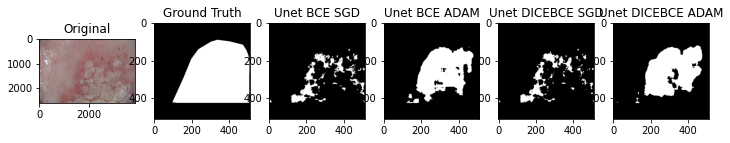

JS1: 0.3303, JS2:0.7790, JS3: 0.4194, JS4: 0.7530


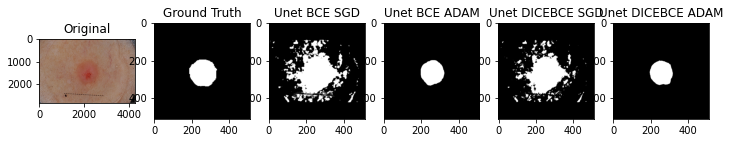

JS1: 0.1705, JS2:0.6222, JS3: 0.1276, JS4: 0.6074


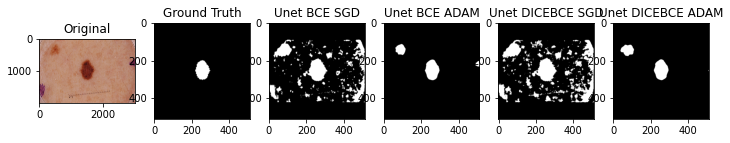

JS1: 0.2803, JS2:0.6368, JS3: 0.2114, JS4: 0.8104


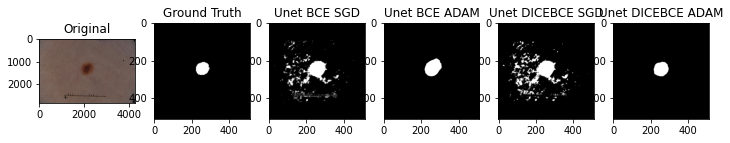

JS1: 0.7191, JS2:0.9384, JS3: 0.7176, JS4: 0.9036


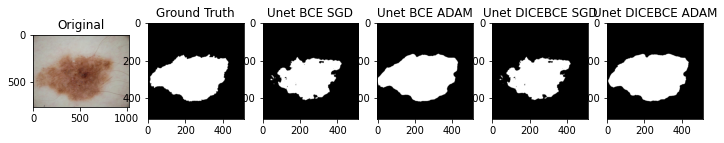

JS1: 0.8065, JS2:0.8724, JS3: 0.8044, JS4: 0.8851


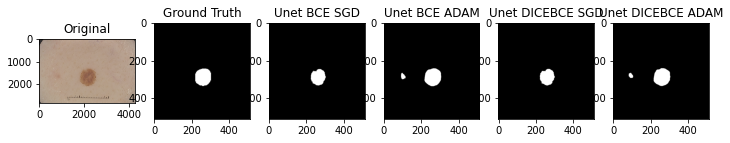

JS1: 0.9058, JS2:0.9160, JS3: 0.9064, JS4: 0.8960


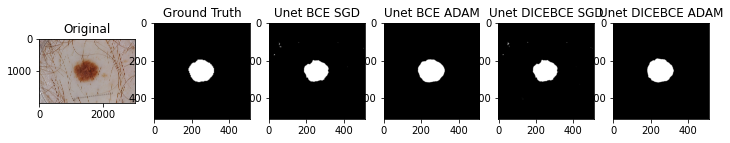

JS1: 0.3873, JS2:0.3105, JS3: 0.4380, JS4: 0.5577


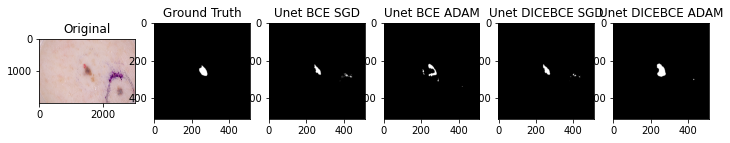

JS1: 0.3480, JS2:0.8987, JS3: 0.3789, JS4: 0.8855


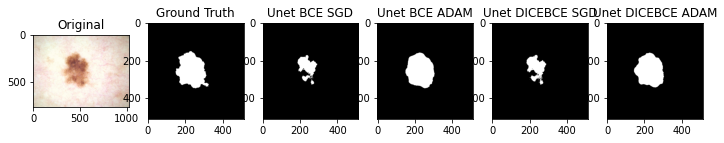

JS1: 0.4262, JS2:0.8075, JS3: 0.4296, JS4: 0.8013


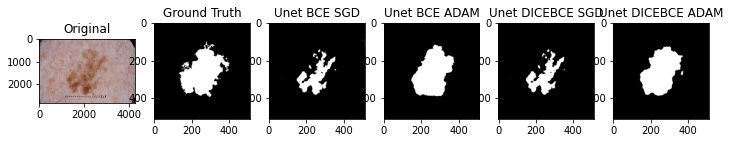

In [75]:
from IPython.core.pylabtools import figsize
df = pd.read_csv(test_csv_path)

samples = df.sample(10)

for idx, row in samples.iterrows():

    img_id = '/' + row['image_id']

    img_path = img_folder + img_id + '.jpg'
    mask_path = seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)

    preds1 = predict(image, unet_bce_sgd, th_unet_bce_sgd)
    preds2 = predict(image, unet_bce_adam, th_unet_bce_adam)
    preds3 = predict(image, unet_dicebce_sgd, th_unet_dicebce_sgd)
    preds4 = predict(image, unet_dicebce_adam, th_unet_dicebce_adam)
    gt = mask.cpu().int().numpy()

   
    js1 =js(gt, preds1/255)
    js2 = js(gt, preds2/255)
    js3 = js(gt, preds3/255)
    js4 = js(gt, preds4/255)

    print(f"JS1: {js1:.4f}, JS2:{js2:.4f}, JS3: {js3:.4f}, JS4: {js4:.4f}")
    

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols = 6, figsize=(12, 5))

    ax1.imshow(np.array(img))
    ax1.set_title('Original')
         
    ax2.imshow(np.array(mask)[0, :, :], cmap='gray')
    ax2.set_title('Ground Truth')

    ax3.imshow(preds1, cmap='gray')
    ax3.set_title('Unet BCE SGD')

    ax4.imshow(preds2, cmap='gray')
    ax4.set_title('Unet BCE ADAM')

    ax5.imshow(preds3, cmap='gray')
    ax5.set_title('Unet DICEBCE SGD')

    ax6.imshow(preds4, cmap='gray')
    ax6.set_title('Unet DICEBCE ADAM')

    plt.subplots_adjust()
    plt.show()

## 2. *U-NET with Attention*

### Prepare data

#### Data Transforms

In [86]:
# Parameters
NEW_SIZE = 512

# Calculated from the original training set 
mu = [0.7145, 0.6030, 0.5589] # mean
std =  [0.1064, 0.1277, 0.1493] # Standard deviation

In [87]:
# Transforms for preprocessing, we will use the same for all datasets here
img_transforms = transforms.Compose([
                                    MakeSquare(is_mask= False), # For original images
                                    transforms.Resize((NEW_SIZE, NEW_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mu, std=std)
                                  ]) 

mask_transforms = transforms.Compose([
                                    MakeSquare(is_mask= True), # For segmentation masks 
                                    transforms.Resize((NEW_SIZE, NEW_SIZE)),
                                    transforms.ToTensor(),
                                  ])

#### Datasets 

In [88]:
# Training dataset, will contain 3000 images after augmentation
isic_train = ISIC2017Dataset(csv_file=train_csv_path,
                             image_folder= img_folder,
                             segmentation_folder= seg_folder, 
                             img_transform = img_transforms,
                             mask_transform = mask_transforms)

# Validation dataset, will contain 300 images from the augmented test set
isic_val = ISIC2017Dataset(csv_file=val_csv_path, 
                            image_folder= img_folder, 
                            segmentation_folder= seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms)

In [89]:
# Test dataset, will contain the original 1000 images from ISIC2017
isic_test = ISIC2017Dataset(csv_file=test_csv_path, 
                            image_folder= img_folder, 
                            segmentation_folder= seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms)

#### Data Loaders

In [90]:
# Parameters
TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
NUM_WORKERS = 2

In [91]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(isic_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(isic_test, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(isic_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

Visualize some images : 

In [92]:
iterator = iter(test_loader)

In [93]:
# Get a batch of training data
data = next(iterator)

inputs = data['image']
masks = data['mask']

# Print shapes
print(inputs.shape)
print(masks.shape)

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


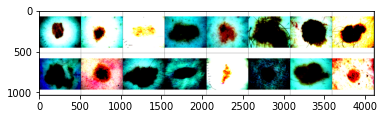

In [94]:
# Show the original images
ins = torchvision.utils.make_grid(inputs)
imshow(ins)

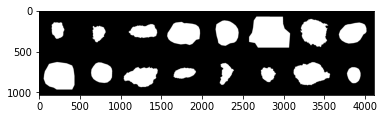

In [95]:
# Show the corresponding segmentation masks
out = torchvision.utils.make_grid(masks)
imshow(out)


### *Train*

In [96]:
# Global parameters (same for all training procedures for U-Net)
LEARNING_RATE = 1e-5 # Base learning rate, this worked best in previous experiements
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs 
N_CHANNELS = 3 # number of input channels
N_CLASSES = 1 # 1 object to be detected => skin lesion
LR_PATIENCE = 5 # If the loss does not improve after 5 epochs reduce the learning rate 
ES_PATIENCE = 10  # If the validation dice does not improve for this much epochs stop training 

#### With BCE Loss 

##### With SGD optimizer

In [ ]:
# Parameters
CHECKPOINT_ATT_UNET_BCE_SGD = '/content/drive/MyDrive/models/att_unet_BCE_SGD_aug.pth' # save model to this file
MOMENTUM = 0.9 # Momentum parameter for the optimizer

In [ ]:
# create a new U-Net model
att_unet_bce_sgd = AttU_Net(img_ch=N_CHANNELS, output_ch=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.SGD(att_unet_bce_sgd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_unet_bce_sgd, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

In [ ]:
train_net(att_unet_bce_sgd, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_ATT_UNET_BCE_SGD, # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
att_unet_bce_sgd.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_BCE_SGD))
att_unet_bce_sgd.eval()

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, att_unet_bce_sgd, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_att_unet_bce_sgd = optimizer.max['params']['th']
print(f"The optimal threshold is {th_att_unet_bce_sgd:.4f}")

##### With ADAM optimizer

In [ ]:
# Parameters 
CHECKPOINT_ATT_UNET_BCE_ADAM = '/content/drive/MyDrive/models/att_unet_BCE_ADAM_aug.pth' # save model to this file
WEIGHT_DECAY = 1e-8 #weight decay parameter of ADAM optimizer

In [ ]:
# create a new U-Net model
att_unet_bce_adam = AttU_Net(img_ch=N_CHANNELS, output_ch=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(att_unet_bce_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_unet_bce_adam, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 300img [01:33,  3.22img/s, dice =0.242, loss =14]


Initial val dice: 0.1779, Initial val loss: 0.7343


In [ ]:
train_net(att_unet_bce_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_ATT_UNET_BCE_ADAM, # where to save the model
          True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 3000img [11:25,  4.38img/s, loss (batch)=0.283]


Training Loss: 0.38595


Valid: 300img [00:52,  5.73img/s, dice =0.407, loss =7.07]


Val Dice: 0.3699, Val Loss: 0.3719




Epoch 2/100: 3000img [11:22,  4.40img/s, loss (batch)=0.259]


Training Loss: 0.29930


Valid: 300img [00:52,  5.74img/s, dice =0.427, loss =5.83]


Val Dice: 0.3953, Val Loss: 0.3069




Epoch 3/100: 3000img [11:22,  4.40img/s, loss (batch)=0.29]


Training Loss: 0.27109


Valid: 300img [00:52,  5.73img/s, dice =0.45, loss =5.26]


Val Dice: 0.4195, Val Loss: 0.2770




Epoch 4/100: 3000img [11:22,  4.40img/s, loss (batch)=0.252]


Training Loss: 0.25277


Valid: 300img [00:53,  5.65img/s, dice =0.5, loss =5.14]


Val Dice: 0.4262, Val Loss: 0.2703




Epoch 5/100: 3000img [11:21,  4.40img/s, loss (batch)=0.184]


Training Loss: 0.23558


Valid: 300img [00:51,  5.80img/s, dice =0.529, loss =4.87]


Val Dice: 0.4477, Val Loss: 0.2562




Epoch 6/100: 3000img [11:21,  4.40img/s, loss (batch)=0.197]


Training Loss: 0.22312


Valid: 300img [00:52,  5.71img/s, dice =0.5, loss =4.52]


Val Dice: 0.4480, Val Loss: 0.2379




Epoch 7/100: 3000img [11:21,  4.41img/s, loss (batch)=0.2]


Training Loss: 0.21070


Valid: 300img [00:52,  5.70img/s, dice =0.532, loss =4.85]


Val Dice: 0.4767, Val Loss: 0.2551




Epoch 8/100: 3000img [11:21,  4.40img/s, loss (batch)=0.218]


Training Loss: 0.19915


Valid: 300img [00:52,  5.70img/s, dice =0.552, loss =3.86]


Val Dice: 0.5000, Val Loss: 0.2030




Epoch 9/100: 3000img [11:22,  4.40img/s, loss (batch)=0.177]


Training Loss: 0.19048


Valid: 300img [00:52,  5.70img/s, dice =0.565, loss =3.79]


Val Dice: 0.5130, Val Loss: 0.1997




Epoch 10/100: 3000img [11:22,  4.40img/s, loss (batch)=0.159]


Training Loss: 0.18101


Valid: 300img [00:53,  5.60img/s, dice =0.572, loss =3.82]


Val Dice: 0.5191, Val Loss: 0.2008




Epoch 11/100: 3000img [11:21,  4.40img/s, loss (batch)=0.183]


Training Loss: 0.17058


Valid: 300img [00:53,  5.65img/s, dice =0.607, loss =3.68]


Val Dice: 0.5369, Val Loss: 0.1939




Epoch 12/100: 3000img [11:21,  4.40img/s, loss (batch)=0.154]


Training Loss: 0.16306


Valid: 300img [00:53,  5.62img/s, dice =0.588, loss =3.44]


Val Dice: 0.5441, Val Loss: 0.1809




Epoch 13/100: 3000img [11:22,  4.40img/s, loss (batch)=0.138]


Training Loss: 0.15452


Valid: 300img [00:52,  5.69img/s, dice =0.637, loss =3.44]


Val Dice: 0.5532, Val Loss: 0.1812




Epoch 14/100: 3000img [11:21,  4.40img/s, loss (batch)=0.124]


Training Loss: 0.14741


Valid: 300img [00:53,  5.59img/s, dice =0.644, loss =3.39]


Val Dice: 0.5668, Val Loss: 0.1783




Epoch 15/100: 3000img [11:21,  4.40img/s, loss (batch)=0.132]


Training Loss: 0.14162


Valid: 300img [00:53,  5.62img/s, dice =0.635, loss =3.08]


Val Dice: 0.5726, Val Loss: 0.1620




Epoch 16/100: 3000img [11:21,  4.40img/s, loss (batch)=0.148]


Training Loss: 0.13387


Valid: 300img [00:52,  5.77img/s, dice =0.612, loss =2.94]


Val Dice: 0.5786, Val Loss: 0.1549




Epoch 17/100: 3000img [11:21,  4.40img/s, loss (batch)=0.124]


Training Loss: 0.12829


Valid: 300img [00:52,  5.66img/s, dice =0.663, loss =3.27]


Val Dice: 0.5906, Val Loss: 0.1722




Epoch 18/100: 3000img [11:21,  4.40img/s, loss (batch)=0.103]


Training Loss: 0.12500


Valid: 300img [00:52,  5.75img/s, dice =0.68, loss =3.13]


Val Dice: 0.6068, Val Loss: 0.1647




Epoch 19/100: 3000img [11:21,  4.40img/s, loss (batch)=0.123]


Training Loss: 0.11954


Valid: 300img [00:53,  5.61img/s, dice =0.64, loss =3.02]


Val Dice: 0.5844, Val Loss: 0.1588




Epoch 20/100: 3000img [11:21,  4.40img/s, loss (batch)=0.119]


Training Loss: 0.11632


Valid: 300img [00:53,  5.61img/s, dice =0.644, loss =2.87]


Val Dice: 0.6176, Val Loss: 0.1509




Epoch 21/100: 3000img [11:21,  4.40img/s, loss (batch)=0.115]


Training Loss: 0.10967


Valid: 300img [00:53,  5.63img/s, dice =0.68, loss =3.21]


Val Dice: 0.6193, Val Loss: 0.1690




Epoch 22/100: 3000img [11:21,  4.40img/s, loss (batch)=0.104]


Training Loss: 0.10531


Valid: 300img [00:53,  5.57img/s, dice =0.698, loss =2.69]


Val Dice: 0.6425, Val Loss: 0.1414




Epoch 23/100: 3000img [11:22,  4.40img/s, loss (batch)=0.09]


Training Loss: 0.10033


Valid: 300img [00:53,  5.64img/s, dice =0.686, loss =2.48]


Val Dice: 0.6629, Val Loss: 0.1304




Epoch 24/100: 3000img [11:21,  4.40img/s, loss (batch)=0.11]


Training Loss: 0.09647


Valid: 300img [00:54,  5.55img/s, dice =0.685, loss =2.66]


Val Dice: 0.6492, Val Loss: 0.1401




Epoch 25/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0934]


Training Loss: 0.09230


Valid: 300img [00:54,  5.48img/s, dice =0.726, loss =2.34]


Val Dice: 0.6856, Val Loss: 0.1232




Epoch 26/100: 3000img [11:22,  4.40img/s, loss (batch)=0.101]


Training Loss: 0.09095


Valid: 300img [00:53,  5.62img/s, dice =0.7, loss =2.58]


Val Dice: 0.6681, Val Loss: 0.1358




Epoch 27/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0739]


Training Loss: 0.08685


Valid: 300img [00:53,  5.58img/s, dice =0.725, loss =2.46]


Val Dice: 0.6849, Val Loss: 0.1297




Epoch 28/100: 3000img [11:22,  4.40img/s, loss (batch)=0.11]


Training Loss: 0.08247


Valid: 300img [00:54,  5.53img/s, dice =0.718, loss =2.4]


Val Dice: 0.6704, Val Loss: 0.1262




Epoch 29/100: 3000img [11:21,  4.40img/s, loss (batch)=0.071]


Training Loss: 0.08170


Valid: 300img [00:53,  5.56img/s, dice =0.733, loss =2.29]


Val Dice: 0.7086, Val Loss: 0.1206




Epoch 30/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0802]


Training Loss: 0.07601


Valid: 300img [00:53,  5.63img/s, dice =0.733, loss =2.55]


Val Dice: 0.6826, Val Loss: 0.1344




Epoch 31/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0817]


Training Loss: 0.07500


Valid: 300img [00:53,  5.60img/s, dice =0.744, loss =3.1]


Val Dice: 0.6709, Val Loss: 0.1629




Epoch 32/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0668]


Training Loss: 0.07151


Valid: 300img [00:54,  5.52img/s, dice =0.768, loss =2.32]


Val Dice: 0.7253, Val Loss: 0.1221




Epoch 33/100: 3000img [11:23,  4.39img/s, loss (batch)=0.123]


Training Loss: 0.06839


Valid: 300img [01:05,  4.61img/s, dice =0.752, loss =2.47]


Val Dice: 0.7147, Val Loss: 0.1300




Epoch 34/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0666]


Training Loss: 0.06602


Valid: 300img [00:54,  5.48img/s, dice =0.72, loss =2.46]


Val Dice: 0.7066, Val Loss: 0.1294




Epoch 35/100: 3000img [11:22,  4.40img/s, loss (batch)=0.128]


Training Loss: 0.06373


Valid: 300img [00:54,  5.50img/s, dice =0.759, loss =2.29]


Val Dice: 0.7336, Val Loss: 0.1204




Epoch 36/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0673]


Training Loss: 0.06091


Valid: 300img [00:54,  5.49img/s, dice =0.754, loss =2.42]


Val Dice: 0.7396, Val Loss: 0.1275




Epoch 37/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0443]


Training Loss: 0.05943


Valid: 300img [00:54,  5.55img/s, dice =0.751, loss =2.68]


Val Dice: 0.7225, Val Loss: 0.1410




Epoch 38/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0638]


Training Loss: 0.05674


Valid: 300img [00:54,  5.53img/s, dice =0.776, loss =2.45]


Val Dice: 0.7478, Val Loss: 0.1287




Epoch 39/100: 3000img [11:22,  4.39img/s, loss (batch)=0.0432]


Training Loss: 0.05459


Valid: 300img [00:54,  5.54img/s, dice =0.757, loss =2.34]


Val Dice: 0.7446, Val Loss: 0.1232




Epoch 40/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0498]


Training Loss: 0.05212


Valid: 300img [00:54,  5.53img/s, dice =0.755, loss =2.45]


Val Dice: 0.7476, Val Loss: 0.1289




Epoch 41/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0513]


Training Loss: 0.05085


Valid: 300img [00:59,  5.01img/s, dice =0.795, loss =2.56]


Val Dice: 0.7566, Val Loss: 0.1345




Epoch 42/100: 3000img [11:22,  4.39img/s, loss (batch)=0.0403]


Training Loss: 0.04371


Valid: 300img [01:05,  4.57img/s, dice =0.798, loss =2.38]


Val Dice: 0.7670, Val Loss: 0.1251




Epoch 43/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0382]


Training Loss: 0.04083


Valid: 300img [00:54,  5.54img/s, dice =0.8, loss =2.4]


Val Dice: 0.7676, Val Loss: 0.1263




Epoch 44/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0372]


Training Loss: 0.04009


Valid: 300img [00:55,  5.39img/s, dice =0.793, loss =2.5]


Val Dice: 0.7674, Val Loss: 0.1317




Epoch 45/100: 3000img [11:22,  4.40img/s, loss (batch)=0.038]


Training Loss: 0.03936


Valid: 300img [00:54,  5.54img/s, dice =0.802, loss =2.42]


Val Dice: 0.7693, Val Loss: 0.1275




Epoch 46/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0446]


Training Loss: 0.03859


Valid: 300img [00:53,  5.61img/s, dice =0.794, loss =2.51]


Val Dice: 0.7693, Val Loss: 0.1322




Epoch 47/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0366]


Training Loss: 0.03852


Valid: 300img [00:54,  5.53img/s, dice =0.804, loss =2.47]


Val Dice: 0.7736, Val Loss: 0.1300




Epoch 48/100: 3000img [11:21,  4.40img/s, loss (batch)=0.039]


Training Loss: 0.03742


Valid: 300img [00:54,  5.49img/s, dice =0.806, loss =2.47]


Val Dice: 0.7729, Val Loss: 0.1301




Epoch 49/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0461]


Training Loss: 0.03737


Valid: 300img [00:54,  5.53img/s, dice =0.796, loss =2.51]


Val Dice: 0.7708, Val Loss: 0.1319




Epoch 50/100: 3000img [11:21,  4.40img/s, loss (batch)=0.038]


Training Loss: 0.03725


Valid: 300img [00:54,  5.54img/s, dice =0.8, loss =2.47]


Val Dice: 0.7723, Val Loss: 0.1302




Epoch 51/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0325]


Training Loss: 0.03712


Valid: 300img [00:53,  5.60img/s, dice =0.805, loss =2.46]


Val Dice: 0.7688, Val Loss: 0.1296




Epoch 52/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0386]


Training Loss: 0.03718


Valid: 300img [00:54,  5.47img/s, dice =0.796, loss =2.5]


Val Dice: 0.7730, Val Loss: 0.1317




Epoch 53/100: 3000img [11:22,  4.39img/s, loss (batch)=0.033]


Training Loss: 0.03675


Valid: 300img [00:54,  5.54img/s, dice =0.794, loss =2.53]


Val Dice: 0.7696, Val Loss: 0.1332




Epoch 54/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0359]


Training Loss: 0.03731


Valid: 300img [00:54,  5.48img/s, dice =0.806, loss =2.47]


Val Dice: 0.7742, Val Loss: 0.1299




Epoch 55/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0435]


Training Loss: 0.03689


Valid: 300img [00:53,  5.62img/s, dice =0.79, loss =2.54]


Val Dice: 0.7674, Val Loss: 0.1337




Epoch 56/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0356]


Training Loss: 0.03712


Valid: 300img [00:53,  5.60img/s, dice =0.797, loss =2.48]


Val Dice: 0.7708, Val Loss: 0.1305




Epoch 57/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0322]


Training Loss: 0.03708


Valid: 300img [00:55,  5.38img/s, dice =0.798, loss =2.5]


Val Dice: 0.7681, Val Loss: 0.1318




Epoch 58/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0337]


Training Loss: 0.03697


Valid: 300img [00:54,  5.53img/s, dice =0.805, loss =2.49]


Val Dice: 0.7732, Val Loss: 0.1311




Epoch 59/100: 3000img [11:21,  4.41img/s, loss (batch)=0.0355]


Training Loss: 0.03710


Valid: 300img [00:54,  5.51img/s, dice =0.801, loss =2.49]


Val Dice: 0.7687, Val Loss: 0.1312




Epoch 60/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0416]


Training Loss: 0.03695


Valid: 300img [00:55,  5.44img/s, dice =0.799, loss =2.51]


Val Dice: 0.7704, Val Loss: 0.1322




Epoch 61/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0324]


Training Loss: 0.03725


Valid: 300img [00:53,  5.60img/s, dice =0.804, loss =2.45]


Val Dice: 0.7748, Val Loss: 0.1292




Epoch 62/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0274]


Training Loss: 0.03689


Valid: 300img [00:53,  5.65img/s, dice =0.8, loss =2.5]


Val Dice: 0.7727, Val Loss: 0.1313




Epoch 63/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0395]


Training Loss: 0.03700


Valid: 300img [00:54,  5.49img/s, dice =0.8, loss =2.51]


Val Dice: 0.7709, Val Loss: 0.1321




Epoch 64/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0424]


Training Loss: 0.03679


Valid: 300img [00:54,  5.47img/s, dice =0.794, loss =2.56]


Val Dice: 0.7675, Val Loss: 0.1348




Epoch 65/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0426]


Training Loss: 0.03670


Valid: 300img [00:55,  5.43img/s, dice =0.8, loss =2.49]


Val Dice: 0.7727, Val Loss: 0.1310




Epoch 66/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0348]


Training Loss: 0.03675


Valid: 300img [00:54,  5.53img/s, dice =0.807, loss =2.46]


Val Dice: 0.7732, Val Loss: 0.1294




Epoch 67/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0344]


Training Loss: 0.03679


Valid: 300img [00:54,  5.51img/s, dice =0.803, loss =2.48]


Val Dice: 0.7730, Val Loss: 0.1305




Epoch 68/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0362]


Training Loss: 0.03700


Valid: 300img [00:54,  5.50img/s, dice =0.803, loss =2.49]


Val Dice: 0.7729, Val Loss: 0.1311




Epoch 69/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0347]


Training Loss: 0.03686


Valid: 300img [00:53,  5.56img/s, dice =0.807, loss =2.47]


Val Dice: 0.7709, Val Loss: 0.1301




Epoch 70/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0401]


Training Loss: 0.03669


Valid: 300img [00:53,  5.60img/s, dice =0.799, loss =2.51]


Val Dice: 0.7691, Val Loss: 0.1320




Epoch 71/100: 3000img [11:21,  4.40img/s, loss (batch)=0.0302]


Training Loss: 0.03688


Valid: 300img [00:54,  5.52img/s, dice =0.799, loss =2.52]


Val Dice: 0.7694, Val Loss: 0.1324




Epoch 72/100: 3000img [11:22,  4.40img/s, loss (batch)=0.0368]


Training Loss: 0.03725


Valid: 300img [00:54,  5.53img/s, dice =0.793, loss =2.53]


Val Dice: 0.7725, Val Loss: 0.1329
EARLY STOPPING AFTER 72 EPOCHS


==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
att_unet_bce_adam.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_BCE_ADAM))
att_unet_bce_adam.eval()

AttU_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
  

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, att_unet_bce_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6875   |  0.3745   |
|  2        |  0.6816   |  0.9507   |
|  3        |  0.6874   |  0.373    |
|  4        |  0.692    |  0.4494   |
|  5        |  0.6974   |  0.5706   |
|  6        |  0.6999   |  0.6834   |
|  7        |  0.1078   |  0.0      |
|  8        |  0.6988   |  0.8267   |
|  9        |  0.0      |  1.0      |
|  10       |  0.6974   |  0.5704   |
|  11       |  0.694    |  0.8971   |
|  12       |  0.7002   |  0.7545   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_att_unet_bce_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_att_unet_bce_adam:.4f}")

The optimal threshold is 0.7545


#### With DiceBCE Loss 

##### With SGD optimizer

In [ ]:
# Parameters
CHECKPOINT_ATT_UNET_DiceBCE_SGD = '/content/drive/MyDrive/models/att_unet_DiceBCE_SGD_aug.pth' # save model to this file
MOMENTUM = 0.9 # Momentum parameter for the optimizer

In [ ]:
# create a new U-Net model
att_unet_dicebce_sgd = AttU_Net(img_ch=N_CHANNELS, output_ch=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.SGD(att_unet_dicebce_sgd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_unet_dicebce_sgd, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

In [ ]:
train_net(att_unet_dicebce_sgd, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_ATT_UNET_DiceBCE_SGD, # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
att_unet_dicebce_sgd.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_DiceBCE_SGD))
att_unet_dicebce_sgd.eval()

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, att_unet_dicebce_sgd, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_att_unet_dicebce_sgd = optimizer.max['params']['th']
print(f"The optimal threshold is {th_att_unet_dicebce_sgd:.4f}")

##### With ADAM optimizer

In [ ]:
# Parameters
CHECKPOINT_ATT_UNET_DiceBCE_ADAM = '/content/drive/MyDrive/models/att_unet_DiceBCE_ADAM_aug.pth' # save model to this file
WEIGHT_DECAY = 1e-8 #weight decay parameter of ADAM optimizer

In [ ]:
# create a new U-Net model
att_unet_dicebce_adam = AttU_Net(img_ch=N_CHANNELS, output_ch=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(att_unet_dicebce_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_unet_dicebce_adam, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 300img [02:57,  1.69img/s, dice =0.238, loss =28.8]


Initial val dice: 0.1753, Initial val loss: 1.5167


In [ ]:
train_net(att_unet_dicebce_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_ATT_UNET_DiceBCE_ADAM , # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 3000img [24:35,  2.03img/s, loss (batch)=0.964]


Training Loss: 0.91241


Valid: 300img [00:59,  5.07img/s, dice =0.402, loss =19.2]


Val Dice: 0.3676, Val Loss: 1.0106




Epoch 2/100: 3000img [07:17,  6.86img/s, loss (batch)=0.823]


Training Loss: 0.75323


Valid: 300img [00:58,  5.11img/s, dice =0.447, loss =17.9]


Val Dice: 0.3976, Val Loss: 0.9429




Epoch 3/100: 3000img [07:17,  6.86img/s, loss (batch)=0.647]


Training Loss: 0.70081


Valid: 300img [00:58,  5.11img/s, dice =0.462, loss =16.9]


Val Dice: 0.4160, Val Loss: 0.8887




Epoch 4/100: 3000img [07:14,  6.90img/s, loss (batch)=0.64]


Training Loss: 0.66266


Valid: 300img [01:00,  4.93img/s, dice =0.523, loss =16.2]


Val Dice: 0.4469, Val Loss: 0.8532




Epoch 5/100: 3000img [07:12,  6.94img/s, loss (batch)=0.543]


Training Loss: 0.63054


Valid: 300img [00:58,  5.11img/s, dice =0.49, loss =15.5]


Val Dice: 0.4479, Val Loss: 0.8163




Epoch 6/100: 3000img [07:11,  6.94img/s, loss (batch)=0.59]


Training Loss: 0.60115


Valid: 300img [00:58,  5.14img/s, dice =0.543, loss =15.3]


Val Dice: 0.4672, Val Loss: 0.8076




Epoch 7/100: 3000img [07:12,  6.94img/s, loss (batch)=0.609]


Training Loss: 0.57714


Valid: 300img [00:58,  5.15img/s, dice =0.53, loss =14.6]


Val Dice: 0.4711, Val Loss: 0.7684




Epoch 8/100: 3000img [07:12,  6.93img/s, loss (batch)=0.754]


Training Loss: 0.55047


Valid: 300img [00:59,  5.02img/s, dice =0.535, loss =14.5]


Val Dice: 0.4812, Val Loss: 0.7658




Epoch 9/100: 3000img [07:11,  6.95img/s, loss (batch)=0.546]


Training Loss: 0.52840


Valid: 300img [00:59,  5.05img/s, dice =0.556, loss =13.7]


Val Dice: 0.5044, Val Loss: 0.7237




Epoch 10/100: 3000img [07:12,  6.94img/s, loss (batch)=0.552]


Training Loss: 0.51298


Valid: 300img [00:58,  5.11img/s, dice =0.573, loss =13.1]


Val Dice: 0.5161, Val Loss: 0.6888




Epoch 11/100: 3000img [07:11,  6.95img/s, loss (batch)=0.446]


Training Loss: 0.48785


Valid: 300img [00:59,  5.05img/s, dice =0.597, loss =13.3]


Val Dice: 0.5237, Val Loss: 0.6993




Epoch 12/100: 3000img [07:14,  6.90img/s, loss (batch)=0.563]


Training Loss: 0.46836


Valid: 300img [00:59,  5.08img/s, dice =0.622, loss =12.9]


Val Dice: 0.5380, Val Loss: 0.6786




Epoch 13/100: 3000img [07:13,  6.92img/s, loss (batch)=0.38]


Training Loss: 0.45110


Valid: 300img [01:00,  5.00img/s, dice =0.585, loss =12.2]


Val Dice: 0.5484, Val Loss: 0.6434




Epoch 14/100: 3000img [07:14,  6.90img/s, loss (batch)=0.387]


Training Loss: 0.43579


Valid: 300img [01:00,  5.00img/s, dice =0.619, loss =11.8]


Val Dice: 0.5651, Val Loss: 0.6185




Epoch 15/100: 3000img [07:13,  6.92img/s, loss (batch)=0.37]


Training Loss: 0.41722


Valid: 300img [00:58,  5.11img/s, dice =0.634, loss =12.6]


Val Dice: 0.5586, Val Loss: 0.6620




Epoch 16/100: 3000img [07:13,  6.92img/s, loss (batch)=0.335]


Training Loss: 0.40288


Valid: 300img [00:59,  5.04img/s, dice =0.624, loss =12]


Val Dice: 0.5770, Val Loss: 0.6297




Epoch 17/100: 3000img [07:13,  6.92img/s, loss (batch)=0.445]


Training Loss: 0.38332


Valid: 300img [01:00,  4.95img/s, dice =0.646, loss =12]


Val Dice: 0.5751, Val Loss: 0.6335




Epoch 18/100: 3000img [07:15,  6.89img/s, loss (batch)=0.358]


Training Loss: 0.36959


Valid: 300img [00:59,  5.05img/s, dice =0.667, loss =10.8]


Val Dice: 0.5979, Val Loss: 0.5684




Epoch 19/100: 3000img [07:16,  6.88img/s, loss (batch)=0.348]


Training Loss: 0.35094


Valid: 300img [01:00,  4.97img/s, dice =0.637, loss =10.6]


Val Dice: 0.6045, Val Loss: 0.5602




Epoch 20/100: 3000img [07:14,  6.90img/s, loss (batch)=0.292]


Training Loss: 0.33959


Valid: 300img [01:00,  4.99img/s, dice =0.672, loss =10.9]


Val Dice: 0.6118, Val Loss: 0.5713




Epoch 21/100: 3000img [07:12,  6.94img/s, loss (batch)=0.257]


Training Loss: 0.32762


Valid: 300img [01:00,  4.97img/s, dice =0.657, loss =10.2]


Val Dice: 0.6290, Val Loss: 0.5367




Epoch 22/100: 3000img [07:12,  6.94img/s, loss (batch)=0.288]


Training Loss: 0.31628


Valid: 300img [01:00,  5.00img/s, dice =0.658, loss =10.1]


Val Dice: 0.6346, Val Loss: 0.5321




Epoch 23/100: 3000img [07:12,  6.94img/s, loss (batch)=0.356]


Training Loss: 0.29891


Valid: 300img [00:59,  5.07img/s, dice =0.673, loss =9.67]


Val Dice: 0.6419, Val Loss: 0.5088




Epoch 24/100: 3000img [07:11,  6.94img/s, loss (batch)=0.306]


Training Loss: 0.29177


Valid: 300img [01:01,  4.91img/s, dice =0.665, loss =10.3]


Val Dice: 0.6388, Val Loss: 0.5444




Epoch 25/100: 3000img [07:11,  6.94img/s, loss (batch)=0.362]


Training Loss: 0.27852


Valid: 300img [00:59,  5.06img/s, dice =0.725, loss =9.2]


Val Dice: 0.6646, Val Loss: 0.4840




Epoch 26/100: 3000img [07:11,  6.95img/s, loss (batch)=0.282]


Training Loss: 0.26516


Valid: 300img [01:01,  4.89img/s, dice =0.677, loss =9.24]


Val Dice: 0.6658, Val Loss: 0.4861




Epoch 27/100: 3000img [07:11,  6.95img/s, loss (batch)=0.256]


Training Loss: 0.26271


Valid: 300img [01:00,  4.93img/s, dice =0.703, loss =9.67]


Val Dice: 0.6583, Val Loss: 0.5091




Epoch 28/100: 3000img [07:14,  6.90img/s, loss (batch)=0.21]


Training Loss: 0.24785


Valid: 300img [00:59,  5.04img/s, dice =0.724, loss =8.92]


Val Dice: 0.6807, Val Loss: 0.4695




Epoch 29/100: 3000img [07:12,  6.93img/s, loss (batch)=0.246]


Training Loss: 0.23839


Valid: 300img [01:00,  4.92img/s, dice =0.722, loss =9.27]


Val Dice: 0.6817, Val Loss: 0.4881




Epoch 30/100: 3000img [07:11,  6.95img/s, loss (batch)=0.297]


Training Loss: 0.22504


Valid: 300img [00:59,  5.03img/s, dice =0.738, loss =8.84]


Val Dice: 0.6943, Val Loss: 0.4655




Epoch 31/100: 3000img [07:11,  6.95img/s, loss (batch)=0.161]


Training Loss: 0.21563


Valid: 300img [00:59,  5.06img/s, dice =0.749, loss =8.46]


Val Dice: 0.7092, Val Loss: 0.4455




Epoch 32/100: 3000img [07:11,  6.94img/s, loss (batch)=0.192]


Training Loss: 0.21152


Valid: 300img [01:01,  4.84img/s, dice =0.752, loss =8.03]


Val Dice: 0.7181, Val Loss: 0.4224




Epoch 33/100: 3000img [07:11,  6.96img/s, loss (batch)=0.201]


Training Loss: 0.20064


Valid: 300img [00:58,  5.13img/s, dice =0.759, loss =8.23]


Val Dice: 0.7179, Val Loss: 0.4331




Epoch 34/100: 3000img [07:12,  6.94img/s, loss (batch)=0.129]


Training Loss: 0.19275


Valid: 300img [01:01,  4.90img/s, dice =0.761, loss =8.29]


Val Dice: 0.7200, Val Loss: 0.4363




Epoch 35/100: 3000img [07:11,  6.96img/s, loss (batch)=0.192]


Training Loss: 0.18910


Valid: 300img [00:59,  5.08img/s, dice =0.794, loss =8.03]


Val Dice: 0.7242, Val Loss: 0.4228




Epoch 36/100: 3000img [07:12,  6.94img/s, loss (batch)=0.139]


Training Loss: 0.18147


Valid: 300img [00:59,  5.02img/s, dice =0.77, loss =7.7]


Val Dice: 0.7330, Val Loss: 0.4051




Epoch 37/100: 3000img [07:13,  6.93img/s, loss (batch)=0.195]


Training Loss: 0.16974


Valid: 300img [01:00,  4.93img/s, dice =0.744, loss =7.89]


Val Dice: 0.7309, Val Loss: 0.4153




Epoch 38/100: 3000img [07:13,  6.92img/s, loss (batch)=0.167]


Training Loss: 0.16619


Valid: 300img [01:00,  4.92img/s, dice =0.788, loss =7.64]


Val Dice: 0.7422, Val Loss: 0.4022




Epoch 39/100: 3000img [07:12,  6.94img/s, loss (batch)=0.137]


Training Loss: 0.15791


Valid: 300img [01:01,  4.87img/s, dice =0.765, loss =7.66]


Val Dice: 0.7418, Val Loss: 0.4034




Epoch 40/100: 3000img [07:13,  6.92img/s, loss (batch)=0.155]


Training Loss: 0.15115


Valid: 300img [01:02,  4.77img/s, dice =0.761, loss =7.24]


Val Dice: 0.7553, Val Loss: 0.3812




Epoch 41/100: 3000img [07:13,  6.92img/s, loss (batch)=0.151]


Training Loss: 0.14240


Valid: 300img [00:59,  5.04img/s, dice =0.769, loss =7.34]


Val Dice: 0.7560, Val Loss: 0.3864




Epoch 42/100: 3000img [07:13,  6.92img/s, loss (batch)=0.104]


Training Loss: 0.14108


Valid: 300img [01:00,  4.99img/s, dice =0.789, loss =7.44]


Val Dice: 0.7561, Val Loss: 0.3918




Epoch 43/100: 3000img [07:14,  6.90img/s, loss (batch)=0.138]


Training Loss: 0.13268


Valid: 300img [01:00,  4.97img/s, dice =0.775, loss =7.33]


Val Dice: 0.7612, Val Loss: 0.3856




Epoch 44/100: 3000img [07:14,  6.90img/s, loss (batch)=0.135]


Training Loss: 0.13866


Valid: 300img [00:59,  5.06img/s, dice =0.798, loss =7.31]


Val Dice: 0.7631, Val Loss: 0.3849




Epoch 45/100: 3000img [07:13,  6.92img/s, loss (batch)=0.132]


Training Loss: 0.12822


Valid: 300img [01:00,  4.97img/s, dice =0.776, loss =7.66]


Val Dice: 0.7584, Val Loss: 0.4034




Epoch 46/100: 3000img [07:13,  6.93img/s, loss (batch)=0.0933]


Training Loss: 0.11608


Valid: 300img [00:58,  5.09img/s, dice =0.778, loss =7.57]


Val Dice: 0.7647, Val Loss: 0.3987




Epoch 47/100: 3000img [07:12,  6.94img/s, loss (batch)=0.11]


Training Loss: 0.10265


Valid: 300img [00:59,  5.01img/s, dice =0.795, loss =7.12]


Val Dice: 0.7756, Val Loss: 0.3748




Epoch 48/100: 3000img [07:12,  6.94img/s, loss (batch)=0.108]


Training Loss: 0.09877


Valid: 300img [01:00,  4.95img/s, dice =0.784, loss =7.61]


Val Dice: 0.7677, Val Loss: 0.4004




Epoch 49/100: 3000img [07:12,  6.94img/s, loss (batch)=0.107]


Training Loss: 0.09698


Valid: 300img [01:00,  4.95img/s, dice =0.789, loss =7.34]


Val Dice: 0.7717, Val Loss: 0.3864




Epoch 50/100: 3000img [07:12,  6.93img/s, loss (batch)=0.0716]


Training Loss: 0.09480


Valid: 300img [01:01,  4.85img/s, dice =0.793, loss =7.25]


Val Dice: 0.7734, Val Loss: 0.3813




Epoch 51/100: 3000img [07:14,  6.91img/s, loss (batch)=0.106]


Training Loss: 0.09421


Valid: 300img [00:59,  5.03img/s, dice =0.799, loss =7.18]


Val Dice: 0.7760, Val Loss: 0.3777




Epoch 52/100: 3000img [07:15,  6.89img/s, loss (batch)=0.0701]


Training Loss: 0.09165


Valid: 300img [01:00,  5.00img/s, dice =0.795, loss =7.35]


Val Dice: 0.7745, Val Loss: 0.3866




Epoch 53/100: 3000img [07:14,  6.90img/s, loss (batch)=0.0926]


Training Loss: 0.09151


Valid: 300img [00:59,  5.02img/s, dice =0.801, loss =7.17]


Val Dice: 0.7782, Val Loss: 0.3774




Epoch 54/100: 3000img [07:14,  6.91img/s, loss (batch)=0.0978]


Training Loss: 0.09080


Valid: 300img [01:00,  4.97img/s, dice =0.801, loss =7.27]


Val Dice: 0.7761, Val Loss: 0.3828




Epoch 55/100: 3000img [07:16,  6.88img/s, loss (batch)=0.0902]


Training Loss: 0.08894


Valid: 300img [00:59,  5.02img/s, dice =0.802, loss =7.21]


Val Dice: 0.7780, Val Loss: 0.3795




Epoch 56/100: 3000img [07:15,  6.89img/s, loss (batch)=0.0762]


Training Loss: 0.08977


Valid: 300img [01:00,  5.00img/s, dice =0.801, loss =7.16]


Val Dice: 0.7791, Val Loss: 0.3771




Epoch 57/100: 3000img [07:15,  6.89img/s, loss (batch)=0.0813]


Training Loss: 0.08969


Valid: 300img [01:01,  4.86img/s, dice =0.799, loss =7.29]


Val Dice: 0.7768, Val Loss: 0.3838




Epoch 58/100: 3000img [07:15,  6.89img/s, loss (batch)=0.124]


Training Loss: 0.08868


Valid: 300img [00:59,  5.04img/s, dice =0.803, loss =7.24]


Val Dice: 0.7774, Val Loss: 0.3809




Epoch 59/100: 3000img [07:15,  6.89img/s, loss (batch)=0.0769]


Training Loss: 0.08885


Valid: 300img [00:59,  5.07img/s, dice =0.804, loss =7.2]


Val Dice: 0.7778, Val Loss: 0.3791




Epoch 60/100: 3000img [07:15,  6.89img/s, loss (batch)=0.0682]


Training Loss: 0.08848


Valid: 300img [01:02,  4.82img/s, dice =0.805, loss =7.28]


Val Dice: 0.7772, Val Loss: 0.3831




Epoch 61/100: 3000img [07:14,  6.90img/s, loss (batch)=0.0708]


Training Loss: 0.08971


Valid: 300img [01:01,  4.90img/s, dice =0.798, loss =7.31]


Val Dice: 0.7769, Val Loss: 0.3846




Epoch 62/100: 3000img [07:12,  6.93img/s, loss (batch)=0.102]


Training Loss: 0.08927


Valid: 300img [01:00,  4.96img/s, dice =0.808, loss =7.24]


Val Dice: 0.7783, Val Loss: 0.3810




Epoch 63/100: 3000img [07:11,  6.95img/s, loss (batch)=0.0726]


Training Loss: 0.08946


Valid: 300img [00:58,  5.14img/s, dice =0.808, loss =7.22]


Val Dice: 0.7782, Val Loss: 0.3802




Epoch 64/100: 3000img [07:11,  6.95img/s, loss (batch)=0.164]


Training Loss: 0.08767


Valid: 300img [01:00,  4.94img/s, dice =0.804, loss =7.37]


Val Dice: 0.7742, Val Loss: 0.3877




Epoch 65/100: 3000img [07:12,  6.94img/s, loss (batch)=0.131]


Training Loss: 0.08848


Valid: 300img [00:59,  5.01img/s, dice =0.805, loss =7.37]


Val Dice: 0.7748, Val Loss: 0.3880




Epoch 66/100: 3000img [07:11,  6.95img/s, loss (batch)=0.0839]


Training Loss: 0.08867


Valid: 300img [01:00,  4.97img/s, dice =0.805, loss =7.33]


Val Dice: 0.7757, Val Loss: 0.3860




Epoch 67/100: 3000img [07:12,  6.94img/s, loss (batch)=0.0623]


Training Loss: 0.08886


Valid: 300img [01:01,  4.92img/s, dice =0.801, loss =7.29]


Val Dice: 0.7767, Val Loss: 0.3834
EARLY STOPPING AFTER 67 EPOCHS


==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
att_unet_dicebce_adam.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_DiceBCE_ADAM))
att_unet_dicebce_adam.eval()

AttU_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
  

In [101]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, att_unet_dicebce_adam, threshold= th, device=DEVICE)

In [102]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6875   |  0.3745   |
|  2        |  0.697    |  0.9507   |
|  3        |  0.6968   |  0.9523   |
|  4        |  0.6971   |  0.8511   |
|  5        |  0.694    |  0.6882   |
|  6        |  0.1078   |  0.0      |
|  7        |  0.6906   |  0.5112   |
|  8        |  0.6891   |  0.4371   |
|  9        |  0.6924   |  0.6065   |
|  10       |  0.0      |  1.0      |
|  11       |  0.6932   |  0.6475   |
|  12       |  0.6915   |  0.558    |


In [103]:
# retrieve the threshold that gave the best result on the validation set 
th_att_unet_dicebce_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_att_unet_dicebce_adam:.4f}")

The optimal threshold is 0.8511


### *Test*

Check Dice score, Jaccard score and Loss on the Test set for trained models:

In [97]:
CHECKPOINT_ATT_UNET_BCE_ADAM = '/content/drive/MyDrive/models/att_unet_BCE_ADAM_aug.pth'
CHECKPOINT_ATT_UNET_DiceBCE_ADAM = '/content/drive/MyDrive/models/att_unet_DiceBCE_ADAM_aug.pth'

In [ ]:
# dice, loss = evaluate(att_unet_bce_sgd, test_loader, criterion, DEVICE)
# jacc = check_js(val_loader, att_unet_bce_sgd, threshold= th_att_unet_bce_sgd, device=DEVICE)
# print("Model: ATTENTION-UNET, Optimizer: SGD, Loss: BCE")
# print(f'Test Dice: {dice:.4f}')
# print(f'Test Loss: {loss:.4f}')
# print(f'Test Jaccard: {jacc:.4f}')

In [98]:
# Attention-Unet trained with BCE Loss and ADAM optimizer
att_unet_bce_adam = AttU_Net(img_ch=N_CHANNELS, output_ch=N_CLASSES).to(DEVICE)
att_unet_bce_adam.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_BCE_ADAM))
att_unet_bce_adam.eval()

th_att_unet_bce_adam = 0.7545

criterion = nn.BCEWithLogitsLoss()

In [99]:
dice, loss = evaluate(att_unet_bce_adam, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, att_unet_bce_adam, threshold= th_att_unet_bce_adam, device=DEVICE)
print("Model: ATTENTION-UNET, Optimizer: ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 1000img [06:00,  2.78img/s, dice =0.863, loss =0.241]


Model: ATTENTION-UNET, Optimizer: ADAM, Loss: BCE
Test Dice: 0.7495
Test Loss: 0.1083
Test Jaccard: 0.7085


In [ ]:
# # Unet trained with DiceBCE Loss and SGD optimizer
# dice, loss = evaluate(att_unet_dicebce_sgd, test_loader, criterion, DEVICE)
# jacc = check_js(val_loader, att_unet_dicebce_sgd, threshold= th_att_unet_dicebce_sgd, device=DEVICE)
# print("Model: ATTENTION-UNET, Optimizer: SGD, Loss: Dice + BCE")
# print(f'Test Dice: {dice:.4f}')
# print(f'Test Loss: {loss:.4f}')
# print(f'Test Jaccard: {jacc:.4f}')

In [104]:
# Attention-Unet trained with Dice + BCE Loss and ADAM optimizer
att_unet_dicebce_adam = AttU_Net(img_ch=N_CHANNELS, output_ch=N_CLASSES).to(DEVICE)
att_unet_dicebce_adam.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_DiceBCE_ADAM))
att_unet_dicebce_adam.eval()

th_att_unet_dicebce_adam = 0.8511

criterion = DiceBCELoss()

In [106]:
dice, loss = evaluate(att_unet_dicebce_adam, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, att_unet_dicebce_adam, threshold= th_att_unet_dicebce_adam, device=DEVICE)
print("Model: ATTENTION-UNET, Optimizer: ADAM, Loss: Dice + BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 1000img [03:29,  4.77img/s, dice =0.864, loss =0.425]


Model: ATTENTION-UNET, Optimizer: ADAM, Loss: Dice + BCE
Test Dice: 0.7543
Test Loss: 0.3762
Test Jaccard: 0.7050


Visualize some results 

JS1: 0.1143, JS2:0.1490


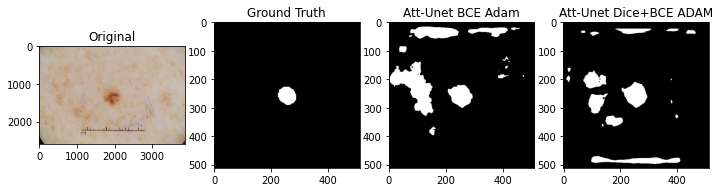

JS1: 0.6149, JS2:0.5632


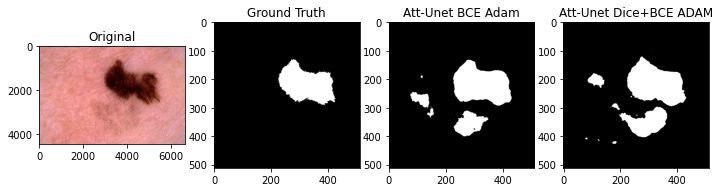

JS1: 0.8857, JS2:0.8962


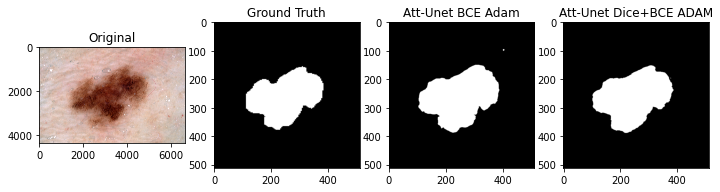

JS1: 0.1287, JS2:0.2156


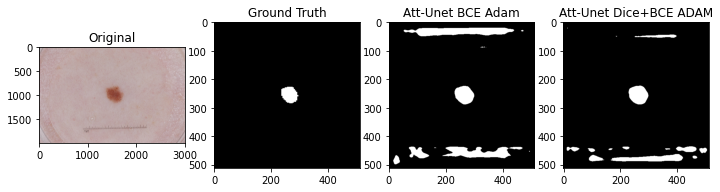

JS1: 0.1658, JS2:0.2834


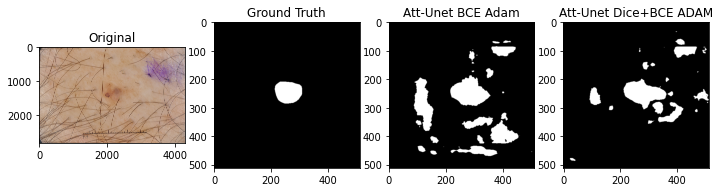

JS1: 0.9054, JS2:0.9161


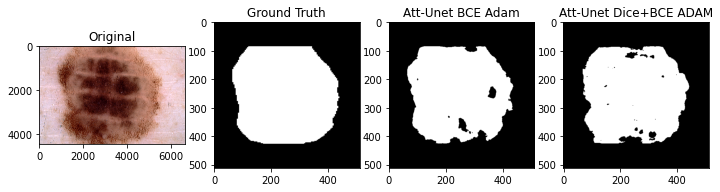

JS1: 0.2226, JS2:0.2672


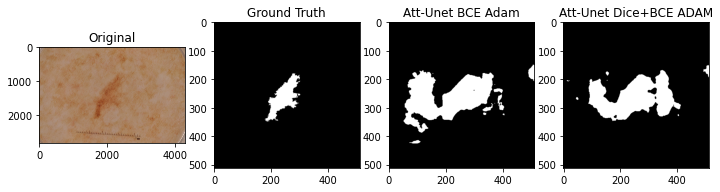

JS1: 0.7193, JS2:0.7583


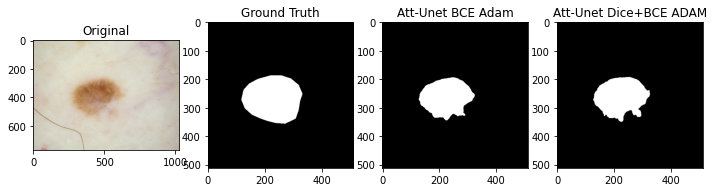

JS1: 0.8979, JS2:0.9201


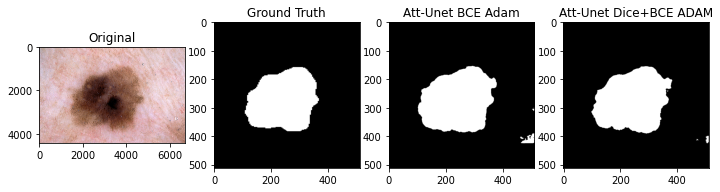

JS1: 0.4314, JS2:0.4415


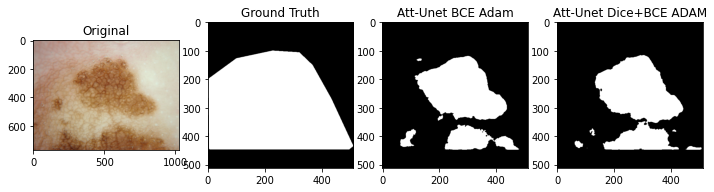

In [107]:
df = pd.read_csv(test_csv_path)

samples = df.sample(10)

for idx, row in samples.iterrows():

    img_id = '/' + row['image_id']

    img_path = img_folder + img_id + '.jpg'
    mask_path = seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)

    preds1 = predict(image, att_unet_bce_adam, th_unet_bce_adam)
    preds2 = predict(image, att_unet_dicebce_adam, th_unet_dicebce_adam)
    gt = mask.cpu().int().numpy()

   
    js1 =js(gt, preds1/255)
    js2 = js(gt, preds2/255)


    print(f"JS1: {js1:.4f}, JS2:{js2:.4f}")
    

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols = 4, figsize=(12, 5))

    ax1.imshow(np.array(img))
    ax1.set_title('Original')
         
    ax2.imshow(np.array(mask)[0, :, :], cmap='gray')
    ax2.set_title('Ground Truth')

    ax3.imshow(preds1, cmap='gray')
    ax3.set_title('Att-Unet BCE Adam')

    ax4.imshow(preds2, cmap='gray')
    ax4.set_title('Att-Unet Dice+BCE ADAM')


    plt.subplots_adjust()
    plt.show()

## 3. *ResNet-Unet (Transfer Learning)*

### Prepare data

#### Data Transforms

In [108]:
# Parameters
NEW_SIZE = 512

# Calculated from the original training set 
mu = [0.7145, 0.6030, 0.5589] # mean
std =  [0.1064, 0.1277, 0.1493] # Standard deviation

In [109]:
# Transforms for preprocessing, we will use the same for all datasets here
img_transforms = transforms.Compose([
                                    MakeSquare(is_mask= False), # For original images
                                    transforms.Resize((NEW_SIZE, NEW_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mu, std=std)
                                  ]) 

mask_transforms = transforms.Compose([
                                    MakeSquare(is_mask= True), # For segmentation masks 
                                    transforms.Resize((NEW_SIZE, NEW_SIZE)),
                                    transforms.ToTensor(),
                                  ])

#### Datasets 

In [110]:
# Training dataset, will contain 3000 images after augmentation
isic_train = ISIC2017Dataset(csv_file=train_csv_path,
                             image_folder= img_folder,
                             segmentation_folder= seg_folder, 
                             img_transform = img_transforms,
                             mask_transform = mask_transforms)

# Validation dataset, will contain 300 images from the augmented test set
isic_val = ISIC2017Dataset(csv_file=val_csv_path, 
                            image_folder= img_folder, 
                            segmentation_folder= seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms)

In [111]:
# Test dataset, will contain the original 1000 images from ISIC2017
isic_test = ISIC2017Dataset(csv_file=test_csv_path, 
                            image_folder= img_folder, 
                            segmentation_folder= seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms)

#### Data Loaders

In [112]:
# Parameters
TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
NUM_WORKERS = 2

In [113]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(isic_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(isic_test, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(isic_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

Visualize some images : 

In [114]:
iterator = iter(test_loader)

In [115]:
# Get a batch of training data
data = next(iterator)

inputs = data['image']
masks = data['mask']

# Print shapes
print(inputs.shape)
print(masks.shape)

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


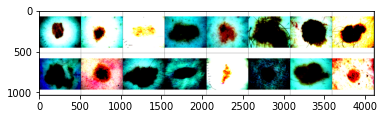

In [116]:
# Show the original images
ins = torchvision.utils.make_grid(inputs)
imshow(ins)

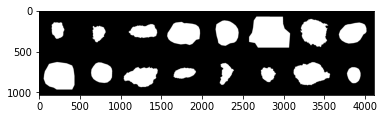

In [117]:
# Show the corresponding segmentation masks
out = torchvision.utils.make_grid(masks)
imshow(out)


### *Train*

In [118]:
# Global parameters (same for all training procedures for U-Net)
LEARNING_RATE = 1e-5 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
N_CLASSES = 1 # 1 object to be detected => skin lesion
LR_PATIENCE = 5 # If the loss does not improve after 5 epochs reduce the learning rate 
ES_PATIENCE = 10  # If the validation dice does not improve for this much epochs stop training 

#### With BCE Loss 

##### With SGD optimizer

In [ ]:
# Parameters
CHECKPOINT_RESNET_UNET_BCE_SGD = '/content/drive/MyDrive/models/resnet_unet_BCE_SGD_aug.pth' # save model to this file
MOMENTUM = 0.9 # Momentum parameter for the optimizer

In [ ]:
# create a new U-Net model
resnet_unet_bce_sgd = ResNetUNet(n_class=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.SGD(resnet_unet_bce_sgd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(resnet_unet_bce_sgd, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

In [ ]:
train_net(resnet_unet_bce_sgd, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_RESNET_UNET_BCE_SGD, # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
resnet_unet_bce_sgd.load_state_dict(torch.load(CHECKPOINT_RESNET_UNET_BCE_SGD))
resnet_unet_bce_sgd.eval()

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, resnet_unet_bce_sgd, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_resnet_unet_bce_sgd = optimizer.max['params']['th']
print(f"The optimal threshold is {th_resnet_unet_bce_sgd:.4f}")

##### With ADAM optimizer

In [ ]:
# Parameters 
CHECKPOINT_RESNET_UNET_BCE_ADAM = '/content/drive/MyDrive/models/resnet_unet_BCE_ADAM_aug.pth' # save model to this file
WEIGHT_DECAY = 1e-8 #weight decay parameter of ADAM optimizer

In [ ]:
# create a new U-Net model
resnet_unet_bce_adam = ResNetUNet(n_class=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(resnet_unet_bce_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(resnet_unet_bce_adam, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 300img [01:34,  3.17img/s, dice =0.234, loss =12.6]


Initial val dice: 0.1726, Initial val loss: 0.6642


In [ ]:
train_net(resnet_unet_bce_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_RESNET_UNET_BCE_ADAM, # where to save the model
          True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 3000img [10:40,  4.68img/s, loss (batch)=0.145]


Training Loss: 0.35126


Valid: 300img [00:50,  5.94img/s, dice =0.481, loss =2.79]


Val Dice: 0.5421, Val Loss: 0.1471




Epoch 2/100: 3000img [06:39,  7.51img/s, loss (batch)=0.11]


Training Loss: 0.14543


Valid: 300img [00:50,  5.96img/s, dice =0.627, loss =2.33]


Val Dice: 0.6671, Val Loss: 0.1227




Epoch 3/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0592]


Training Loss: 0.11144


Valid: 300img [00:50,  5.92img/s, dice =0.722, loss =2.14]


Val Dice: 0.7295, Val Loss: 0.1128




Epoch 4/100: 3000img [06:39,  7.50img/s, loss (batch)=0.133]


Training Loss: 0.09181


Valid: 300img [00:50,  5.97img/s, dice =0.735, loss =2.04]


Val Dice: 0.7498, Val Loss: 0.1072




Epoch 5/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0549]


Training Loss: 0.08030


Valid: 300img [00:50,  5.89img/s, dice =0.769, loss =1.88]


Val Dice: 0.7707, Val Loss: 0.0991




Epoch 6/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0533]


Training Loss: 0.07244


Valid: 300img [00:50,  5.95img/s, dice =0.753, loss =2.07]


Val Dice: 0.7667, Val Loss: 0.1092




Epoch 7/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0657]


Training Loss: 0.06636


Valid: 300img [00:51,  5.87img/s, dice =0.791, loss =1.93]


Val Dice: 0.7885, Val Loss: 0.1017




Epoch 8/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0437]


Training Loss: 0.06334


Valid: 300img [00:51,  5.87img/s, dice =0.768, loss =2.07]


Val Dice: 0.7862, Val Loss: 0.1088




Epoch 9/100: 3000img [06:40,  7.50img/s, loss (batch)=0.0693]


Training Loss: 0.05928


Valid: 300img [00:50,  5.89img/s, dice =0.785, loss =2.27]


Val Dice: 0.7748, Val Loss: 0.1195




Epoch 10/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0807]


Training Loss: 0.05514


Valid: 300img [00:51,  5.88img/s, dice =0.812, loss =2.15]


Val Dice: 0.7940, Val Loss: 0.1132




Epoch 11/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0892]


Training Loss: 0.05238


Valid: 300img [00:51,  5.86img/s, dice =0.804, loss =2.05]


Val Dice: 0.7997, Val Loss: 0.1077




Epoch 12/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0588]


Training Loss: 0.04791


Valid: 300img [00:51,  5.84img/s, dice =0.806, loss =2.07]


Val Dice: 0.8009, Val Loss: 0.1089




Epoch 13/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0461]


Training Loss: 0.04796


Valid: 300img [00:51,  5.85img/s, dice =0.819, loss =2.09]


Val Dice: 0.8014, Val Loss: 0.1099




Epoch 14/100: 3000img [06:39,  7.50img/s, loss (batch)=0.0734]


Training Loss: 0.04749


Valid: 300img [00:51,  5.86img/s, dice =0.817, loss =2.13]


Val Dice: 0.7982, Val Loss: 0.1123




Epoch 15/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0517]


Training Loss: 0.04652


Valid: 300img [00:50,  5.89img/s, dice =0.813, loss =2.2]


Val Dice: 0.8026, Val Loss: 0.1157




Epoch 16/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0508]


Training Loss: 0.04642


Valid: 300img [00:51,  5.83img/s, dice =0.82, loss =2.15]


Val Dice: 0.8022, Val Loss: 0.1130




Epoch 17/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0396]


Training Loss: 0.04629


Valid: 300img [00:51,  5.84img/s, dice =0.815, loss =2.21]


Val Dice: 0.8007, Val Loss: 0.1161




Epoch 18/100: 3000img [06:39,  7.52img/s, loss (batch)=0.0413]


Training Loss: 0.04578


Valid: 300img [00:51,  5.82img/s, dice =0.817, loss =2.16]


Val Dice: 0.8018, Val Loss: 0.1136




Epoch 19/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0493]


Training Loss: 0.04549


Valid: 300img [00:51,  5.77img/s, dice =0.809, loss =2.23]


Val Dice: 0.7986, Val Loss: 0.1176




Epoch 20/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0307]


Training Loss: 0.04556


Valid: 300img [00:51,  5.85img/s, dice =0.808, loss =2.22]


Val Dice: 0.7994, Val Loss: 0.1169




Epoch 21/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0403]


Training Loss: 0.04594


Valid: 300img [00:51,  5.82img/s, dice =0.81, loss =2.21]


Val Dice: 0.8002, Val Loss: 0.1162




Epoch 22/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0534]


Training Loss: 0.04564


Valid: 300img [00:51,  5.82img/s, dice =0.815, loss =2.22]


Val Dice: 0.8021, Val Loss: 0.1168




Epoch 23/100: 3000img [06:39,  7.51img/s, loss (batch)=0.053]


Training Loss: 0.04554


Valid: 300img [00:52,  5.77img/s, dice =0.814, loss =2.22]


Val Dice: 0.8027, Val Loss: 0.1167




Epoch 24/100: 3000img [06:39,  7.50img/s, loss (batch)=0.0364]


Training Loss: 0.04553


Valid: 300img [00:52,  5.73img/s, dice =0.809, loss =2.25]


Val Dice: 0.8003, Val Loss: 0.1186




Epoch 25/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0498]


Training Loss: 0.04531


Valid: 300img [00:52,  5.74img/s, dice =0.815, loss =2.2]


Val Dice: 0.8028, Val Loss: 0.1157




Epoch 26/100: 3000img [06:39,  7.52img/s, loss (batch)=0.078]


Training Loss: 0.04558


Valid: 300img [00:52,  5.72img/s, dice =0.817, loss =2.24]


Val Dice: 0.8034, Val Loss: 0.1181




Epoch 27/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0609]


Training Loss: 0.04584


Valid: 300img [00:52,  5.72img/s, dice =0.82, loss =2.21]


Val Dice: 0.8013, Val Loss: 0.1165




Epoch 28/100: 3000img [06:39,  7.51img/s, loss (batch)=0.037]


Training Loss: 0.04570


Valid: 300img [00:52,  5.75img/s, dice =0.807, loss =2.22]


Val Dice: 0.8001, Val Loss: 0.1169




Epoch 29/100: 3000img [06:39,  7.50img/s, loss (batch)=0.0431]


Training Loss: 0.04548


Valid: 300img [00:52,  5.71img/s, dice =0.818, loss =2.19]


Val Dice: 0.8028, Val Loss: 0.1155




Epoch 30/100: 3000img [06:39,  7.50img/s, loss (batch)=0.0431]


Training Loss: 0.04532


Valid: 300img [00:52,  5.70img/s, dice =0.818, loss =2.21]


Val Dice: 0.8026, Val Loss: 0.1164




Epoch 31/100: 3000img [06:40,  7.50img/s, loss (batch)=0.0345]


Training Loss: 0.04530


Valid: 300img [00:52,  5.70img/s, dice =0.817, loss =2.18]


Val Dice: 0.8011, Val Loss: 0.1148




Epoch 32/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0784]


Training Loss: 0.04579


Valid: 300img [00:52,  5.68img/s, dice =0.817, loss =2.23]


Val Dice: 0.8020, Val Loss: 0.1174




Epoch 33/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0534]


Training Loss: 0.04578


Valid: 300img [00:53,  5.62img/s, dice =0.814, loss =2.18]


Val Dice: 0.8008, Val Loss: 0.1147




Epoch 34/100: 3000img [06:40,  7.50img/s, loss (batch)=0.0445]


Training Loss: 0.04535


Valid: 300img [00:53,  5.61img/s, dice =0.812, loss =2.24]


Val Dice: 0.7977, Val Loss: 0.1180




Epoch 35/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0417]


Training Loss: 0.04533


Valid: 300img [00:53,  5.61img/s, dice =0.815, loss =2.25]


Val Dice: 0.8019, Val Loss: 0.1184




Epoch 36/100: 3000img [06:39,  7.50img/s, loss (batch)=0.0372]


Training Loss: 0.04538


Valid: 300img [00:53,  5.61img/s, dice =0.814, loss =2.26]


Val Dice: 0.8012, Val Loss: 0.1189




Epoch 37/100: 3000img [06:38,  7.52img/s, loss (batch)=0.0572]


Training Loss: 0.04552


Valid: 300img [00:53,  5.60img/s, dice =0.816, loss =2.16]


Val Dice: 0.8036, Val Loss: 0.1139




Epoch 38/100: 3000img [06:40,  7.49img/s, loss (batch)=0.0365]


Training Loss: 0.04559


Valid: 300img [00:52,  5.67img/s, dice =0.81, loss =2.22]


Val Dice: 0.8026, Val Loss: 0.1167




Epoch 39/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0372]


Training Loss: 0.04575


Valid: 300img [00:52,  5.71img/s, dice =0.815, loss =2.2]


Val Dice: 0.8011, Val Loss: 0.1155




Epoch 40/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0322]


Training Loss: 0.04580


Valid: 300img [00:52,  5.72img/s, dice =0.813, loss =2.22]


Val Dice: 0.8015, Val Loss: 0.1171




Epoch 41/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0695]


Training Loss: 0.04495


Valid: 300img [00:52,  5.69img/s, dice =0.816, loss =2.21]


Val Dice: 0.8030, Val Loss: 0.1162




Epoch 42/100: 3000img [06:39,  7.52img/s, loss (batch)=0.0505]


Training Loss: 0.04559


Valid: 300img [00:52,  5.68img/s, dice =0.812, loss =2.18]


Val Dice: 0.8010, Val Loss: 0.1147




Epoch 43/100: 3000img [06:39,  7.51img/s, loss (batch)=0.044]


Training Loss: 0.04501


Valid: 300img [00:52,  5.72img/s, dice =0.806, loss =2.26]


Val Dice: 0.7972, Val Loss: 0.1189




Epoch 44/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0444]


Training Loss: 0.04543


Valid: 300img [00:53,  5.64img/s, dice =0.815, loss =2.15]


Val Dice: 0.8033, Val Loss: 0.1134




Epoch 45/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0419]


Training Loss: 0.04576


Valid: 300img [00:53,  5.64img/s, dice =0.812, loss =2.21]


Val Dice: 0.8009, Val Loss: 0.1162




Epoch 46/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0375]


Training Loss: 0.04533


Valid: 300img [00:53,  5.62img/s, dice =0.816, loss =2.23]


Val Dice: 0.8014, Val Loss: 0.1173




Epoch 47/100: 3000img [06:39,  7.51img/s, loss (batch)=0.107]


Training Loss: 0.04598


Valid: 300img [00:53,  5.61img/s, dice =0.819, loss =2.19]


Val Dice: 0.8062, Val Loss: 0.1152




Epoch 48/100: 3000img [06:40,  7.50img/s, loss (batch)=0.0402]


Training Loss: 0.04572


Valid: 300img [00:52,  5.68img/s, dice =0.817, loss =2.16]


Val Dice: 0.8033, Val Loss: 0.1137




Epoch 49/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0481]


Training Loss: 0.04521


Valid: 300img [00:53,  5.64img/s, dice =0.815, loss =2.22]


Val Dice: 0.7988, Val Loss: 0.1170




Epoch 50/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0939]


Training Loss: 0.04553


Valid: 300img [00:53,  5.63img/s, dice =0.816, loss =2.22]


Val Dice: 0.8048, Val Loss: 0.1170




Epoch 51/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0463]


Training Loss: 0.04546


Valid: 300img [00:53,  5.64img/s, dice =0.815, loss =2.21]


Val Dice: 0.8007, Val Loss: 0.1165




Epoch 52/100: 3000img [06:39,  7.50img/s, loss (batch)=0.0429]


Training Loss: 0.04539


Valid: 300img [00:53,  5.62img/s, dice =0.818, loss =2.2]


Val Dice: 0.8008, Val Loss: 0.1159




Epoch 53/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0406]


Training Loss: 0.04526


Valid: 300img [00:53,  5.62img/s, dice =0.811, loss =2.23]


Val Dice: 0.7996, Val Loss: 0.1174




Epoch 54/100: 3000img [06:39,  7.50img/s, loss (batch)=0.0476]


Training Loss: 0.04523


Valid: 300img [00:53,  5.60img/s, dice =0.82, loss =2.2]


Val Dice: 0.8031, Val Loss: 0.1155




Epoch 55/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0503]


Training Loss: 0.04569


Valid: 300img [00:53,  5.62img/s, dice =0.817, loss =2.19]


Val Dice: 0.8031, Val Loss: 0.1152




Epoch 56/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0683]


Training Loss: 0.04536


Valid: 300img [00:53,  5.65img/s, dice =0.811, loss =2.21]


Val Dice: 0.8017, Val Loss: 0.1165




Epoch 57/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0343]


Training Loss: 0.04537


Valid: 300img [00:53,  5.64img/s, dice =0.818, loss =2.17]


Val Dice: 0.8042, Val Loss: 0.1142




Epoch 58/100: 3000img [06:40,  7.49img/s, loss (batch)=0.0377]


Training Loss: 0.04563


Valid: 300img [00:53,  5.65img/s, dice =0.81, loss =2.26]


Val Dice: 0.7988, Val Loss: 0.1189
EARLY STOPPING AFTER 58 EPOCHS


==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
resnet_unet_bce_adam.load_state_dict(torch.load(CHECKPOINT_RESNET_UNET_BCE_ADAM))
resnet_unet_bce_adam.eval()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, resnet_unet_bce_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6961   |  0.3745   |
|  2        |  0.6511   |  0.9507   |
|  3        |  0.696    |  0.373    |
|  4        |  0.1078   |  0.0      |
|  5        |  0.7059   |  0.692    |
|  6        |  0.7062   |  0.5603   |
|  7        |  0.6969   |  0.8195   |
|  8        |  0.7035   |  0.4806   |
|  9        |  0.7033   |  0.7532   |
|  10       |  0.7068   |  0.6243   |
|  11       |  0.7006   |  0.4303   |
|  12       |  0.7066   |  0.6563   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_resnet_unet_bce_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_resnet_unet_bce_adam:.4f}")

The optimal threshold is 0.6243


#### With DiceBCE Loss 

##### With SGD optimizer

In [ ]:
# Parameters
CHECKPOINT_RESNET_UNET_DiceBCE_SGD = '/content/drive/MyDrive/models/resnet_unet_DiceBCE_SGD_aug.pth' # save model to this file
MOMENTUM = 0.9 # Momentum parameter for the optimizer

In [ ]:
# create a new U-Net model
resnet_unet_dicebce_sgd = ResNetUNet(n_class=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.SGD(resnet_unet_dicebce_sgd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(resnet_unet_dicebce_sgd, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

In [ ]:
train_net(resnet_unet_dicebce_sgd, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_RESNET_UNET_DiceBCE_SGD, # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
resnet_unet_dicebce_sgd.load_state_dict(torch.load(CHECKPOINT_RESNET_UNET_DiceBCE_SGD))
resnet_unet_dicebce_sgd.eval()

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, resnet_unet_dicebce_sgd, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_resnet_unet_dicebce_sgd = optimizer.max['params']['th']
print(f"The optimal threshold is {th_resnet_unet_dicebce_sgd:.4f}")

##### With ADAM optimizer

In [ ]:
# Parameters
CHECKPOINT_RESNET_UNET_DiceBCE_ADAM = '/content/drive/MyDrive/models/resnet_unet_DiceBCE_ADAM_aug.pth' # save model to this file
WEIGHT_DECAY = 1e-8 #weight decay parameter of ADAM optimizer

In [ ]:
# create a new U-Net model
resnet_unet_dicebce_adam = ResNetUNet(n_class=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(resnet_unet_dicebce_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(resnet_unet_dicebce_adam, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 300img [00:51,  5.79img/s, dice =0.237, loss =29.1]


Initial val dice: 0.1743, Initial val loss: 1.5337


In [ ]:
train_net(resnet_unet_dicebce_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_RESNET_UNET_DiceBCE_ADAM , # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 3000img [06:40,  7.49img/s, loss (batch)=0.553]


Training Loss: 0.84944


Valid: 300img [00:52,  5.77img/s, dice =0.563, loss =9.57]


Val Dice: 0.6342, Val Loss: 0.5035




Epoch 2/100: 3000img [06:40,  7.50img/s, loss (batch)=0.252]


Training Loss: 0.34690


Valid: 300img [00:51,  5.81img/s, dice =0.695, loss =7.19]


Val Dice: 0.7532, Val Loss: 0.3784




Epoch 3/100: 3000img [06:40,  7.50img/s, loss (batch)=0.214]


Training Loss: 0.26972


Valid: 300img [00:52,  5.74img/s, dice =0.754, loss =6.58]


Val Dice: 0.7758, Val Loss: 0.3465




Epoch 4/100: 3000img [06:40,  7.50img/s, loss (batch)=0.14]


Training Loss: 0.21703


Valid: 300img [00:52,  5.76img/s, dice =0.765, loss =6.08]


Val Dice: 0.7998, Val Loss: 0.3200




Epoch 5/100: 3000img [06:39,  7.50img/s, loss (batch)=0.198]


Training Loss: 0.18699


Valid: 300img [00:51,  5.82img/s, dice =0.78, loss =6.31]


Val Dice: 0.7927, Val Loss: 0.3319




Epoch 6/100: 3000img [06:40,  7.49img/s, loss (batch)=0.214]


Training Loss: 0.16960


Valid: 300img [00:51,  5.78img/s, dice =0.765, loss =6.27]


Val Dice: 0.7940, Val Loss: 0.3298




Epoch 7/100: 3000img [06:39,  7.51img/s, loss (batch)=0.14]


Training Loss: 0.15897


Valid: 300img [00:51,  5.82img/s, dice =0.803, loss =5.93]


Val Dice: 0.8120, Val Loss: 0.3122




Epoch 8/100: 3000img [06:40,  7.49img/s, loss (batch)=0.117]


Training Loss: 0.14757


Valid: 300img [00:51,  5.79img/s, dice =0.791, loss =6.43]


Val Dice: 0.7957, Val Loss: 0.3385




Epoch 9/100: 3000img [06:39,  7.50img/s, loss (batch)=0.148]


Training Loss: 0.14189


Valid: 300img [00:51,  5.78img/s, dice =0.809, loss =5.95]


Val Dice: 0.8133, Val Loss: 0.3133




Epoch 10/100: 3000img [06:40,  7.50img/s, loss (batch)=0.144]


Training Loss: 0.13287


Valid: 300img [00:51,  5.83img/s, dice =0.819, loss =5.9]


Val Dice: 0.8169, Val Loss: 0.3103




Epoch 11/100: 3000img [06:40,  7.50img/s, loss (batch)=0.0824]


Training Loss: 0.12562


Valid: 300img [00:52,  5.74img/s, dice =0.816, loss =5.89]


Val Dice: 0.8240, Val Loss: 0.3098




Epoch 12/100: 3000img [06:40,  7.50img/s, loss (batch)=0.117]


Training Loss: 0.12171


Valid: 300img [00:51,  5.78img/s, dice =0.839, loss =5.8]


Val Dice: 0.8244, Val Loss: 0.3051




Epoch 13/100: 3000img [06:40,  7.50img/s, loss (batch)=0.138]


Training Loss: 0.11459


Valid: 300img [00:52,  5.74img/s, dice =0.836, loss =5.86]


Val Dice: 0.8273, Val Loss: 0.3085




Epoch 14/100: 3000img [06:39,  7.51img/s, loss (batch)=0.089]


Training Loss: 0.10784


Valid: 300img [00:52,  5.73img/s, dice =0.829, loss =6.03]


Val Dice: 0.8256, Val Loss: 0.3174




Epoch 15/100: 3000img [06:39,  7.50img/s, loss (batch)=0.12]


Training Loss: 0.10489


Valid: 300img [00:51,  5.77img/s, dice =0.822, loss =5.89]


Val Dice: 0.8278, Val Loss: 0.3102




Epoch 16/100: 3000img [06:39,  7.50img/s, loss (batch)=0.0927]


Training Loss: 0.10158


Valid: 300img [00:51,  5.77img/s, dice =0.812, loss =6.14]


Val Dice: 0.8221, Val Loss: 0.3230




Epoch 17/100: 3000img [06:39,  7.51img/s, loss (batch)=0.1]


Training Loss: 0.09660


Valid: 300img [00:52,  5.74img/s, dice =0.831, loss =6.09]


Val Dice: 0.8302, Val Loss: 0.3206




Epoch 18/100: 3000img [06:39,  7.50img/s, loss (batch)=0.101]


Training Loss: 0.09264


Valid: 300img [00:52,  5.74img/s, dice =0.82, loss =6.12]


Val Dice: 0.8270, Val Loss: 0.3219




Epoch 19/100: 3000img [06:39,  7.51img/s, loss (batch)=0.11]


Training Loss: 0.08755


Valid: 300img [00:52,  5.70img/s, dice =0.826, loss =6.06]


Val Dice: 0.8333, Val Loss: 0.3188




Epoch 20/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0847]


Training Loss: 0.08640


Valid: 300img [00:52,  5.70img/s, dice =0.824, loss =6.16]


Val Dice: 0.8311, Val Loss: 0.3243




Epoch 21/100: 3000img [06:40,  7.50img/s, loss (batch)=0.0808]


Training Loss: 0.08510


Valid: 300img [00:52,  5.71img/s, dice =0.819, loss =6.15]


Val Dice: 0.8325, Val Loss: 0.3235




Epoch 22/100: 3000img [06:39,  7.51img/s, loss (batch)=0.103]


Training Loss: 0.08412


Valid: 300img [00:52,  5.70img/s, dice =0.821, loss =6.2]


Val Dice: 0.8319, Val Loss: 0.3261




Epoch 23/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0941]


Training Loss: 0.08420


Valid: 300img [00:51,  5.78img/s, dice =0.816, loss =6.27]


Val Dice: 0.8302, Val Loss: 0.3300




Epoch 24/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0868]


Training Loss: 0.08333


Valid: 300img [00:52,  5.70img/s, dice =0.818, loss =6.35]


Val Dice: 0.8284, Val Loss: 0.3343




Epoch 25/100: 3000img [06:39,  7.50img/s, loss (batch)=0.067]


Training Loss: 0.08246


Valid: 300img [00:52,  5.68img/s, dice =0.814, loss =6.27]


Val Dice: 0.8310, Val Loss: 0.3301




Epoch 26/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0917]


Training Loss: 0.08256


Valid: 300img [00:52,  5.71img/s, dice =0.82, loss =6.27]


Val Dice: 0.8298, Val Loss: 0.3300




Epoch 27/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0717]


Training Loss: 0.08237


Valid: 300img [00:52,  5.73img/s, dice =0.819, loss =6.31]


Val Dice: 0.8296, Val Loss: 0.3321




Epoch 28/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0809]


Training Loss: 0.08227


Valid: 300img [00:52,  5.70img/s, dice =0.821, loss =6.18]


Val Dice: 0.8326, Val Loss: 0.3252




Epoch 29/100: 3000img [06:39,  7.51img/s, loss (batch)=0.0675]


Training Loss: 0.08219


Valid: 300img [00:53,  5.65img/s, dice =0.821, loss =6.23]


Val Dice: 0.8314, Val Loss: 0.3278




Epoch 30/100: 3000img [06:39,  7.50img/s, loss (batch)=0.0783]


Training Loss: 0.08259


Valid: 300img [00:52,  5.67img/s, dice =0.819, loss =6.23]


Val Dice: 0.8326, Val Loss: 0.3281
EARLY STOPPING AFTER 30 EPOCHS


==> Finding the optimal threshold with Bayesian search

Here we will use the Bayesian Search library to find the optimal threshold using the validation set: 

In [ ]:
# Load the best weights obtained to the model
resnet_unet_dicebce_adam.load_state_dict(torch.load(CHECKPOINT_RESNET_UNET_DiceBCE_ADAM))
resnet_unet_dicebce_adam.eval()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, resnet_unet_dicebce_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.7233   |  0.3745   |
|  2        |  0.7131   |  0.9507   |
|  3        |  0.7233   |  0.373    |
|  4        |  0.727    |  0.5915   |
|  5        |  0.1084   |  0.0      |
|  6        |  0.7264   |  0.7769   |
|  7        |  0.7272   |  0.684    |
|  8        |  0.0      |  1.0      |
|  9        |  0.7272   |  0.684    |
|  10       |  0.7208   |  0.9032   |
|  11       |  0.7248   |  0.8358   |
|  12       |  0.7263   |  0.5242   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_resnet_unet_dicebce_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_resnet_unet_dicebce_adam:.4f}")

The optimal threshold is 0.6840


### *Test*

In [119]:
CHECKPOINT_RESNET_UNET_BCE_ADAM = '/content/drive/MyDrive/models/resnet_unet_BCE_ADAM_aug.pth'
CHECKPOINT_RESNET_UNET_DiceBCE_ADAM = '/content/drive/MyDrive/models/resnet_unet_DiceBCE_ADAM_aug.pth'

Check Dice score, Jaccard score and Loss on the Test set for trained models:

In [ ]:
# Unet trained with BCE Loss and SGD optimizer
# dice, loss = evaluate(resnet_unet_bce_sgd, test_loader, criterion, DEVICE)
# jacc = check_js(val_loader, resnet_unet_bce_sgd, threshold= th_resnet_unet_bce_sgd, device=DEVICE)
# print("Model: RESNET-UNET, Optimizer: SGD, Loss: BCE")
# print(f'Test Dice: {dice:.4f}')
# print(f'Test Loss: {loss:.4f}')
# print(f'Test Jaccard: {jacc:.4f}')

In [120]:
# Unet trained with BCE Loss and ADAM optimizer
# Unet trained with BCE Loss and ADAM optimizer
resnet_unet_bce_adam =  ResNetUNet(n_class=N_CLASSES).to(DEVICE)
resnet_unet_bce_adam.load_state_dict(torch.load(CHECKPOINT_RESNET_UNET_BCE_ADAM))
resnet_unet_bce_adam.eval()

th_resnet_unet_bce_adam = 0.6243

criterion = nn.BCEWithLogitsLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [121]:
dice, loss = evaluate(resnet_unet_bce_adam, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, resnet_unet_bce_adam, threshold= th_resnet_unet_bce_adam, device=DEVICE)
print("Model: RESNET-UNET, Optimizer: ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 1000img [03:16,  5.08img/s, dice =0.87, loss =0.206]


Model: RESNET-UNET, Optimizer: ADAM, Loss: BCE
Test Dice: 0.7915
Test Loss: 0.1028
Test Jaccard: 0.7072


In [ ]:
# Unet trained with DiceBCE Loss and SGD optimizer
# dice, loss = evaluate(resnet_unet_dicebce_sgd, test_loader, criterion, DEVICE)
# jacc = check_js(val_loader, resnet_unet_dicebce_sgd, threshold= th_resnet_unet_dicebce_sgd, device=DEVICE)
# print("Model: RESNET-UNET, Optimizer: SGD, Loss: Dice + BCE")
# print(f'Test Dice: {dice:.4f}')
# print(f'Test Loss: {loss:.4f}')
# print(f'Test Jaccard: {jacc:.4f}')

In [123]:
# Unet trained with Dice + BCE Loss and ADAM optimizer
resnet_unet_dicebce_adam = ResNetUNet(n_class=N_CLASSES).to(DEVICE)
resnet_unet_dicebce_adam.load_state_dict(torch.load(CHECKPOINT_RESNET_UNET_DiceBCE_ADAM))
resnet_unet_dicebce_adam.eval()

th_resnet_unet_dicebce_adam = 0.6840

criterion = DiceBCELoss()

In [124]:
dice, loss = evaluate(resnet_unet_dicebce_adam, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, resnet_unet_dicebce_adam, threshold= th_resnet_unet_dicebce_adam, device=DEVICE)
print("Model: RESNET-UNET, Optimizer: ADAM, Loss: Dice + BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 1000img [03:16,  5.09img/s, dice =0.868, loss =0.488]


Model: RESNET-UNET, Optimizer: ADAM, Loss: Dice + BCE
Test Dice: 0.8250
Test Loss: 0.3179
Test Jaccard: 0.7225


Visualize some results 

JS1: 0.5065, JS2:0.7239


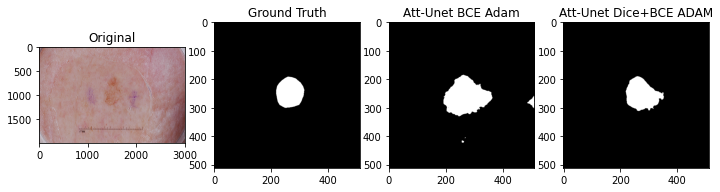

JS1: 0.5377, JS2:0.6023


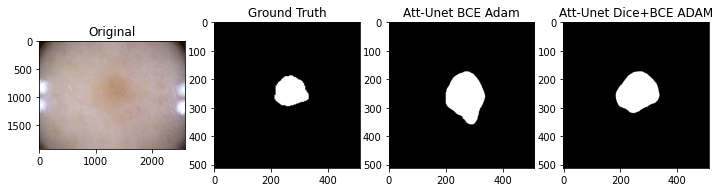

JS1: 0.5645, JS2:0.5232


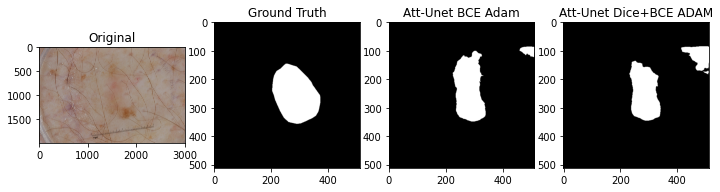

JS1: 0.7977, JS2:0.7444


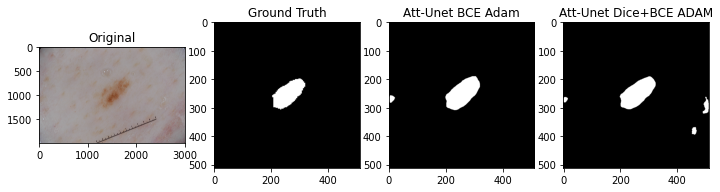

JS1: 0.8023, JS2:0.8191


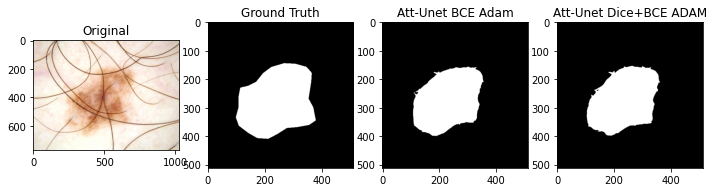

JS1: 0.8459, JS2:0.8474


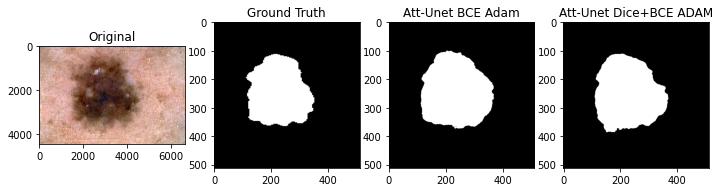

JS1: 0.5535, JS2:0.6978


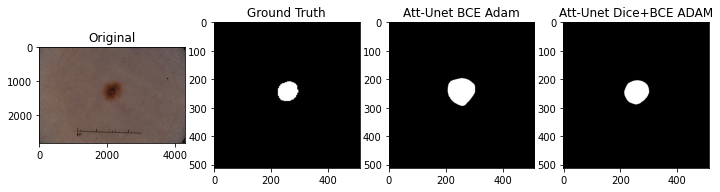

JS1: 0.8398, JS2:0.8806


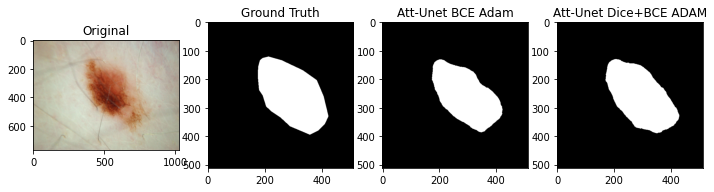

JS1: 0.5811, JS2:0.7510


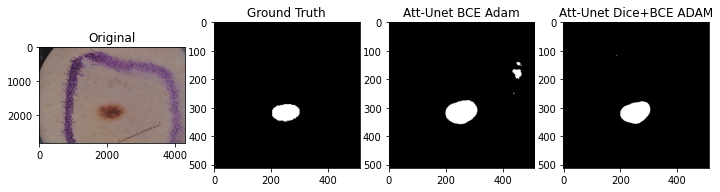

JS1: 0.7494, JS2:0.7856


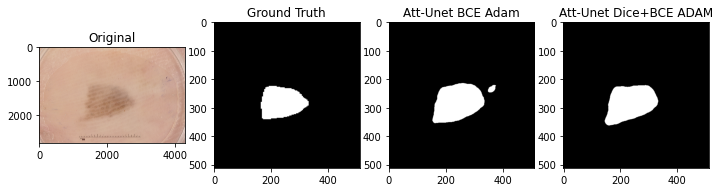

In [125]:
df = pd.read_csv(test_csv_path)

samples = df.sample(10)

for idx, row in samples.iterrows():

    img_id = '/' + row['image_id']

    img_path = img_folder + img_id + '.jpg'
    mask_path = seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)

    preds1 = predict(image, resnet_unet_bce_adam, th_unet_bce_adam)
    preds2 = predict(image, resnet_unet_dicebce_adam, th_unet_dicebce_adam)
    gt = mask.cpu().int().numpy()

   
    js1 =js(gt, preds1/255)
    js2 = js(gt, preds2/255)


    print(f"JS1: {js1:.4f}, JS2:{js2:.4f}")
    

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols = 4, figsize=(12, 5))

    ax1.imshow(np.array(img))
    ax1.set_title('Original')
         
    ax2.imshow(np.array(mask)[0, :, :], cmap='gray')
    ax2.set_title('Ground Truth')

    ax3.imshow(preds1, cmap='gray')
    ax3.set_title('Att-Unet BCE Adam')

    ax4.imshow(preds2, cmap='gray')
    ax4.set_title('Att-Unet Dice+BCE ADAM')


    plt.subplots_adjust()
    plt.show()